# Introdução

Este trabalho utiliza um banco de dados real e público referente ao uso do sistema público de transporte no município de Teresina. O objetivo é desenvolver um modelo para a previsão de passageiros.

De acordo com os problemas que surgirem, utilizaremos algumas técnicas de correção para obter uma análise mais eficiente e usaremos linguagem python e utlizaremos pacotes de acordo com a necessidade da operação

In [1]:
import pandas as pd
import numpy as np
import glob 

# pacote gráficos
import seaborn as sns
import matplotlib.pyplot as plt
import pmdarima as pm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data

%matplotlib inline

from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


# configuração dos gráficos 
from matplotlib import rc
# estilo dos gráficos #https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
plt.style.use('Solarize_Light2')
%config InlineBackend.figure_format = 'retina'  # formato das imagens
rc('font', **{"family":"sans-serif","sans-serif":["DejaVu Sans"], "size":10})

rc('mathtext', **{"default":"regular"})

import warnings
warnings.filterwarnings("ignore")

Construímos duas funções para iniciar o processo de trabalho de análise de dados, a primeira, *files()* tem como objetivo carregar todos os arquivos que iremos trabalhar. Possuímos a limitação que o banco de dados não é conectado a nenhum sistema, como SQL ou algum tipo cloud. Para superar essa dificuldade, realizamos o download considerando um período mensal. 

Ao após a inclusão dos dados, a função construída realiza a união do arquivos num único arquivo para podermos manipular unidos.

A função *pas()* constroi outro arquivo com a quantidade de passageiros diários, que iremos utlizar para realizar a previsão de passageiros.

In [2]:
# função para carregar os data.frames
def files(year): # format YY
    all_files = glob.glob("ano_" + str(year) + "_*.csv")
    df = pd.concat((pd.read_csv(f, encoding='ISO-8859-1', on_bad_lines='skip', sep = ';', decimal = ",") for f in all_files))
    df = df[(df['Tipo Viagem'] == 11)] # eliminando viagens para garagens 
    df['Data Coleta'] = pd.to_datetime(df['Data Coleta'], format='%d/%m/%Y')
    diario = df.groupby('Data Coleta')['Passageiros'].agg('sum')
    diario = diario.reset_index()
    diario['Data Coleta'] = pd.to_datetime(diario['Data Coleta'])
    diario['dia_semana'] = diario['Data Coleta'].dt.dayofweek
    #print(len(diario))
    return(diario)

freq_pas = files(22)

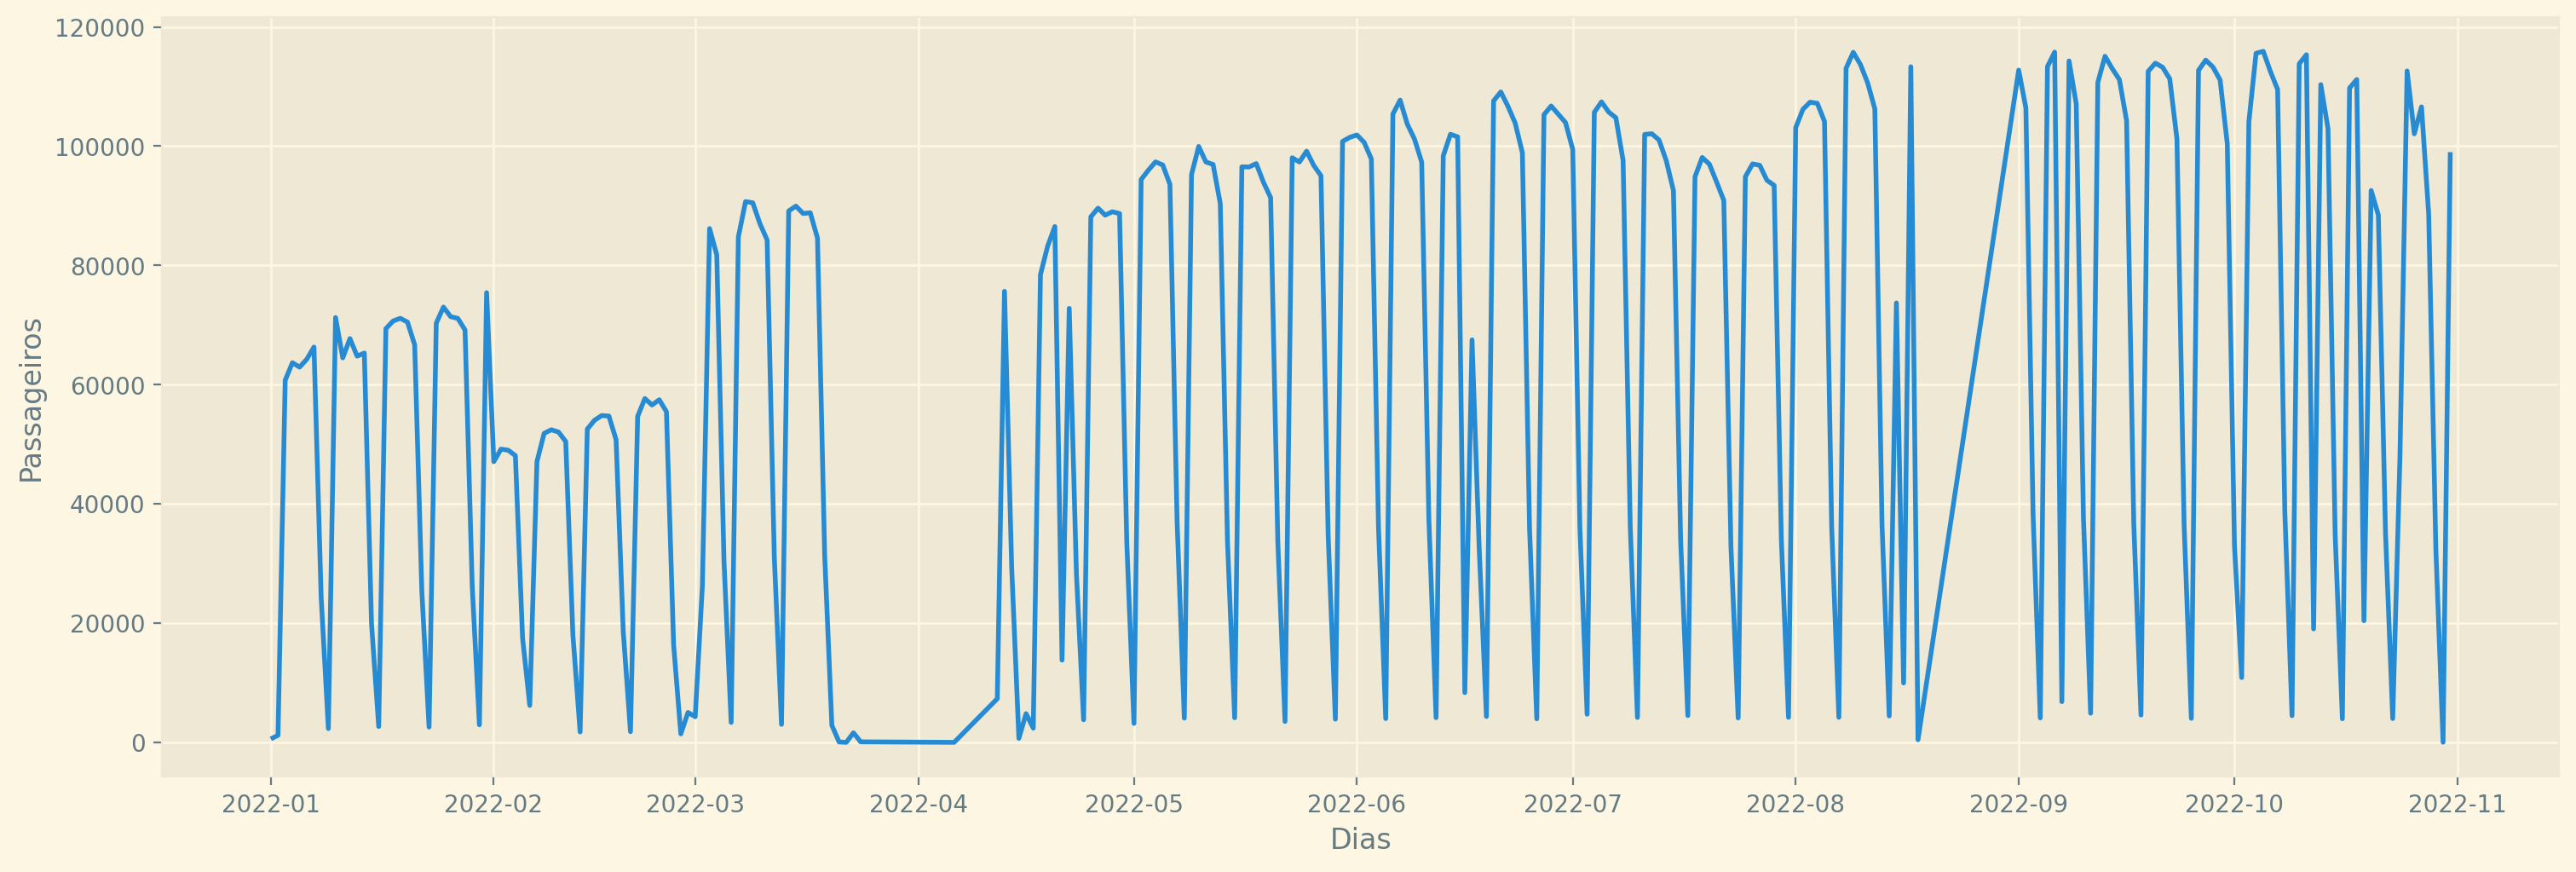

In [3]:
# gráfico com a vizualização da linha do tempo de 2022
def plot_ts():
    fig, ax = plt.subplots(constrained_layout=True)
    fig.set_size_inches(15, 5)
    sns.lineplot(x = freq_pas['Data Coleta'], y = freq_pas['Passageiros'])
    ax.set_xlabel('Dias')
    plt.show()

plot_ts()

O gráfico da série temporal indica que existe uma sanzonalidade semanal, mas evindencia problemas que teremos que tratar para fazer a predição com série temporal. O mais evidente é o período zerado, que corresponde ao período de greve de 23 dias dos motoristas e cobradores de ônibus. Outro fator que pode prejudicar a criação de uma predição são feriados pois ocorrem uma diminuição significativa do número de passageiros. 

Link notícia greve: https://g1.globo.com/pi/piaui/noticia/2022/04/12/chega-ao-fim-greve-de-motoristas-e-cobradores-de-onibus-em-teresina-apos-23-dias.ghtml

A tabela a seguir apresenta as medidas descritivas mais importantes e o problema dos valores mínimos. 

O único dia que tem um valor mais próximo da realidade é o domingo.

Importante destacar que o valor mínimo irá influenciar o valor da média e do desvio-padrão devido ao seu inclusão para os cálculos dessas medidas.

In [4]:
# tabela com medidas descritivas

def medidas(freq_pas):
    data_day = freq_pas.groupby('dia_semana')['Passageiros'].describe().round(2).reset_index()
    data_day = data_day.set_index('dia_semana')
    return(data_day)

data_day = medidas(freq_pas)
data_day

,count,mean,std,min,25%,50%,75%,max
dia_semana,,,,,,,,
0,40.0,83984.00,30549.58,26.0,71009.00,95048.5,105303.75,113803.0
1,39.0,84991.46,33666.52,1.0,67575.50,97335.0,108405.00,115768.0
2,40.0,79814.40,34240.50,0.0,61350.00,96884.0,104107.25,115903.0
3,40.0,81796.85,33022.00,89.0,64648.50,94128.0,105211.00,114292.0
4,38.0,84476.00,22282.10,672.0,70071.75,91140.5,99307.00,109493.0
5,39.0,30102.05,8988.70,575.0,27221.50,33653.0,35988.00,38663.0
6,39.0,3706.67,1667.67,23.0,2900.00,3984.0,4200.00,10867.0


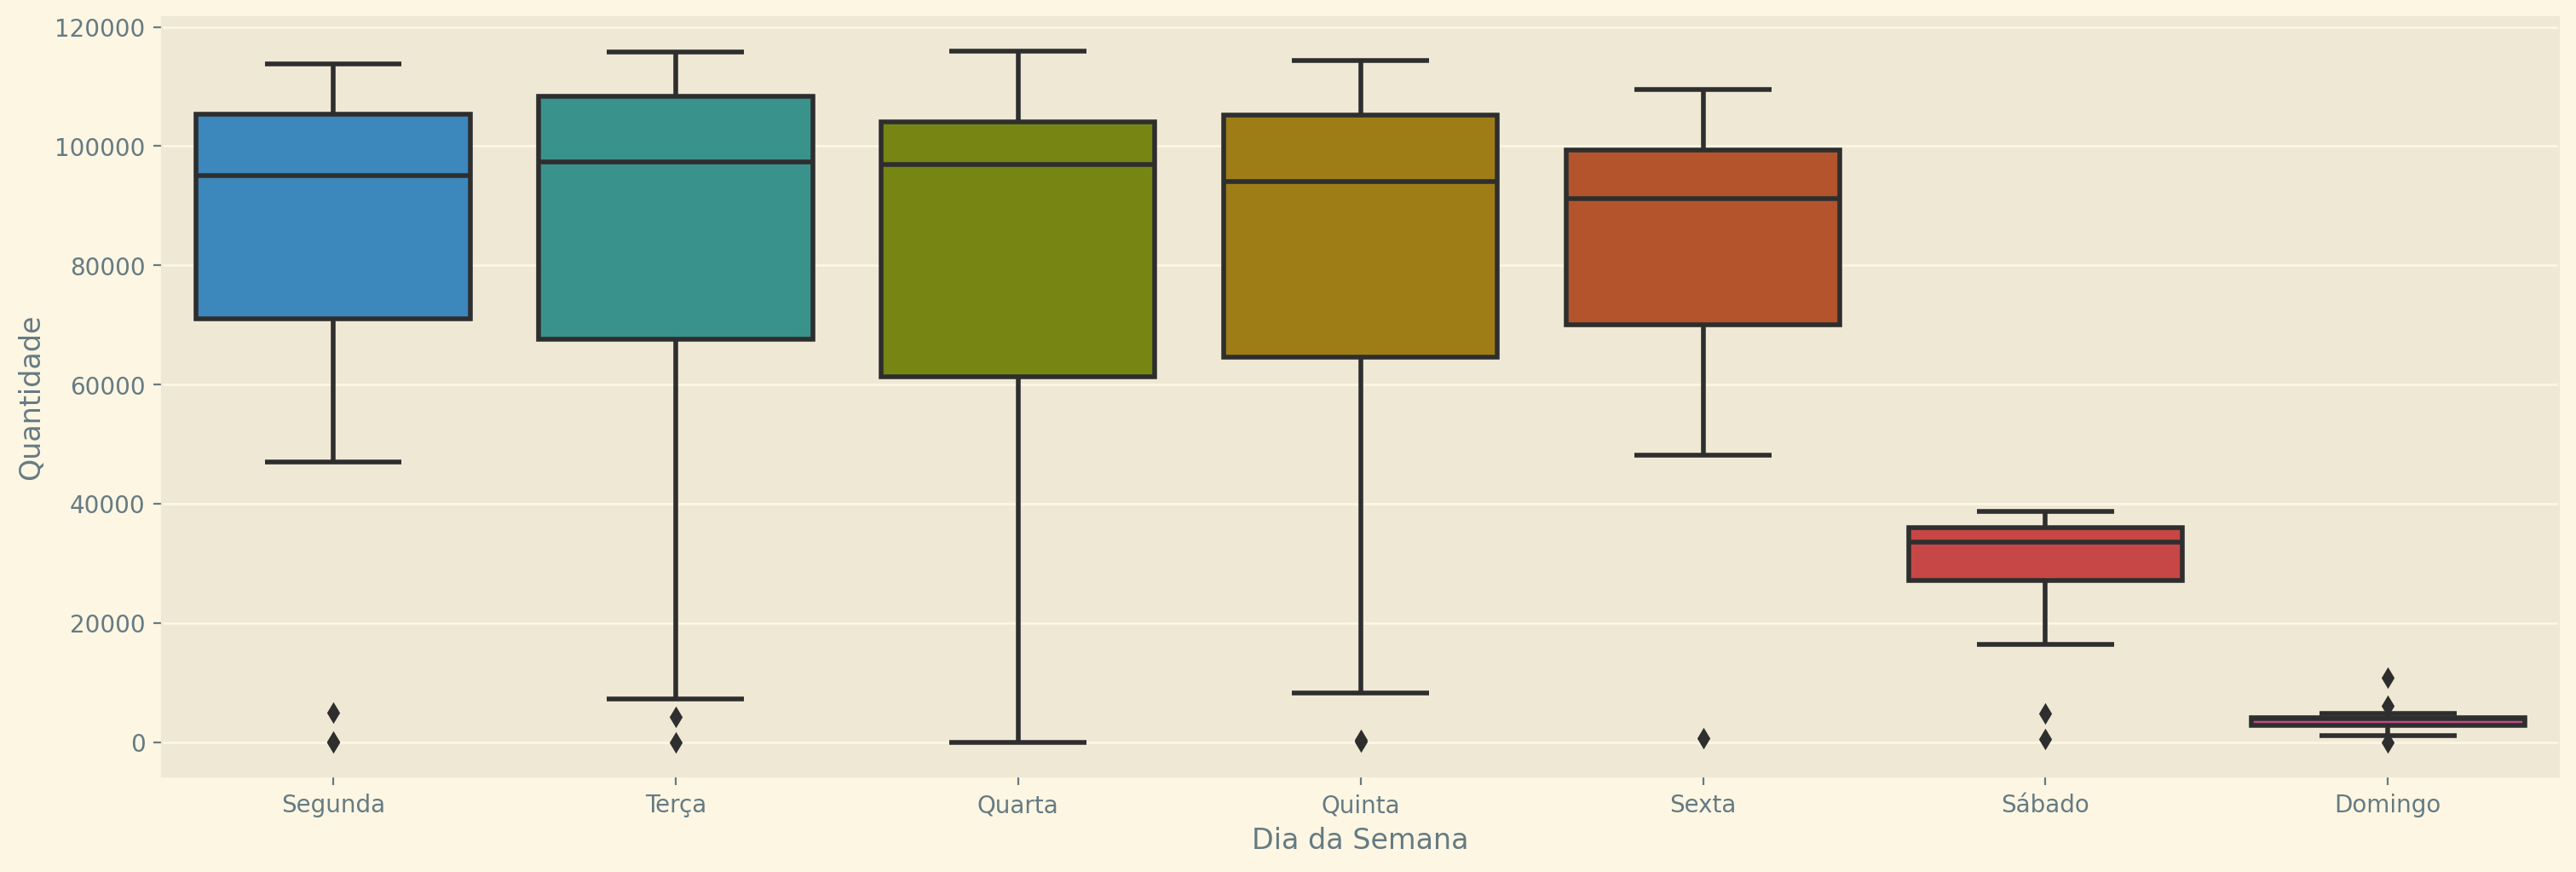

In [5]:
# box-plot com a divisão dos passageiros durante os dias da semana

def box_day(freq_pas):
    fig, ax = plt.subplots(constrained_layout=True)
    fig.set_size_inches(15, 5)
    sns.boxplot(x = freq_pas['dia_semana'], y = freq_pas['Passageiros'])
    ax.set_ylabel('Quantidade')
    ax.set_xlabel('Dia da Semana')
    ax.set_xticklabels(["Segunda", "Terça", "Quarta", "Quinta", "Sexta", "Sábado", "Domingo"]) 
    plt.show()

box_original = box_day(freq_pas)
box_original

# Correção dos dados

Diante desses dados inexistes e irreais, teremos que definir estimadores para substituir os valores. Para isso, o primeiro procedimento foi retirar os valores muitos baixos e muito altos, os outlines existentes no gráfico. 

Para os dias úteis, limitamos esses valores a 50 mil como limite inferior e 125 mil como limite superior, para sábado, o limite inferior foi estabelecido em 18 mil e com um máximo de 40 mil. Para o domingo, foi imposto um limite mínimo de 1000 e máximo de 15 mil.

Na tabela abaixo, podemos ler medidas descritivas mais próximas realistas e o box-plot confirmando as informações de forma gráfica. 

Com essas medidas, podemos estabelecer valores para substituir os valores ausentes ou errados. 

In [6]:
freq_pas = freq_pas.drop(freq_pas[(freq_pas.Passageiros < 50000) & (freq_pas.dia_semana < 5)].index) # valores baixos
freq_pas = freq_pas.drop(freq_pas[(freq_pas.Passageiros > 125000) & (freq_pas.dia_semana < 5)].index) # valores altos

# filtrando para sábado 
freq_pas = freq_pas.drop(freq_pas[(freq_pas.Passageiros < 18000) & (freq_pas.dia_semana == 5)].index) # valores baixos
freq_pas = freq_pas.drop(freq_pas[(freq_pas.Passageiros > 40000) & (freq_pas.dia_semana == 5)].index) # valores altos

#filtrando para domingo
freq_pas = freq_pas.drop(freq_pas[(freq_pas.Passageiros > 15000) & (freq_pas.dia_semana == 6)].index) # valores altos
freq_pas = freq_pas.drop(freq_pas[(freq_pas.Passageiros < 1000) & (freq_pas.dia_semana == 6)].index)

data_day_c= medidas(freq_pas)
data_day_c

,count,mean,std,min,25%,50%,75%,max
dia_semana,,,,,,,,
0,35.0,93128.57,17542.89,52544.0,81602.50,98049.0,105528.00,113803.0
1,34.0,95470.79,19464.42,51836.0,89685.50,100708.5,110655.75,115768.0
2,33.0,93007.79,18655.03,52430.0,86512.00,97360.0,105721.00,115903.0
3,34.0,93262.38,18182.69,52045.0,87449.25,96885.5,107036.50,114292.0
4,36.0,87814.36,16581.05,50460.0,79509.00,91960.5,99689.00,109493.0
5,34.0,32846.41,4946.92,18552.0,31635.25,34062.5,36134.75,38663.0
6,38.0,3803.61,1574.77,1188.0,2960.00,3987.0,4201.00,10867.0


In [7]:

data_day_c

,count,mean,std,min,25%,50%,75%,max
dia_semana,,,,,,,,
0,35.0,93128.57,17542.89,52544.0,81602.50,98049.0,105528.00,113803.0
1,34.0,95470.79,19464.42,51836.0,89685.50,100708.5,110655.75,115768.0
2,33.0,93007.79,18655.03,52430.0,86512.00,97360.0,105721.00,115903.0
3,34.0,93262.38,18182.69,52045.0,87449.25,96885.5,107036.50,114292.0
4,36.0,87814.36,16581.05,50460.0,79509.00,91960.5,99689.00,109493.0
5,34.0,32846.41,4946.92,18552.0,31635.25,34062.5,36134.75,38663.0
6,38.0,3803.61,1574.77,1188.0,2960.00,3987.0,4201.00,10867.0


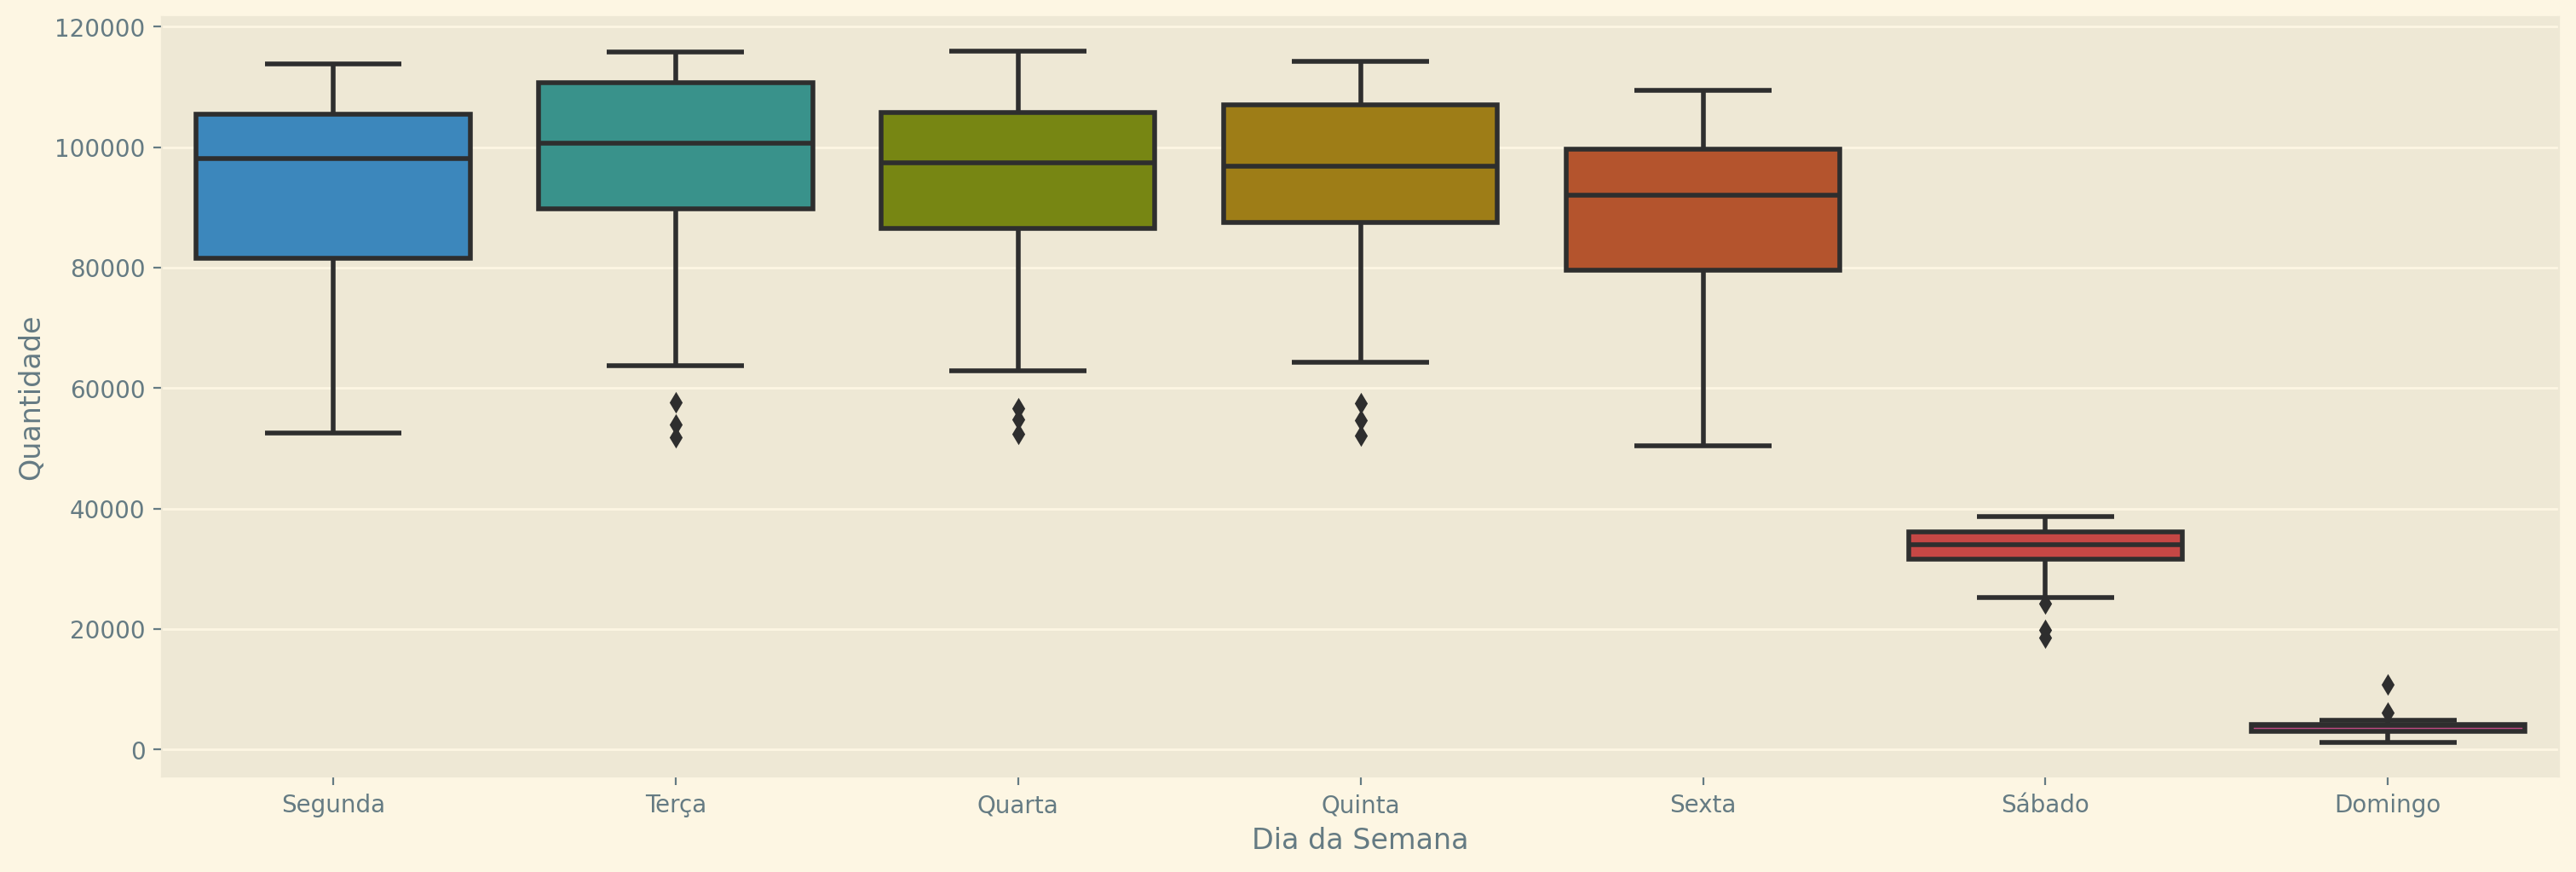

In [8]:
box_day(freq_pas)


Diante dos dados outliers presentes provinientes dos feriados e aos dias sem contagem devido a greve, precisamos encontrar um forma de substituir esses valores. 

O procedimento adotado consiste em analisar a distribuição por dia da semana e realizar o teste de normalidade de Shapiro-will $(\chi^{2})$. Caso seja constatado a normalidade, o valor será substituído pela média, caso não haja normalidade, pela mediana.

O teste de $\chi^{2}$ tem como $H_{0}$ a normalidade dos dados e como $H_{1}$ a não normalidade. Para  valor de significância foi adotado o padrão de 0,05, o que significa um intervalo de confiança  de 95%.

Este método foi definido pois podemos identificar que existe um comportamento diferente para cada dia da semana, buscando não alterar a distribuição dos dados, realizamos uma análise que considera os dados em ralação a cada dia da semana. 

In [9]:

def shapiro_test_days():
    day_0 = freq_pas[freq_pas['dia_semana'] == 0]; shapiro_0 = stats.shapiro(day_0['Passageiros'])
    day_1 = freq_pas[freq_pas['dia_semana'] == 1]; shapiro_1 = stats.shapiro(day_1['Passageiros'])
    day_2 = freq_pas[freq_pas['dia_semana'] == 2]; shapiro_2 = stats.shapiro(day_2['Passageiros'])
    day_3 = freq_pas[freq_pas['dia_semana'] == 3]; shapiro_3 = stats.shapiro(day_3['Passageiros'])
    day_4 = freq_pas[freq_pas['dia_semana'] == 4]; shapiro_4 = stats.shapiro(day_4['Passageiros'])
    #filtrando sabado 
    day_5 = freq_pas.query("dia_semana == 5")
    shapiro_5 = stats.shapiro(day_5['Passageiros'])
    # teste para domingo 
    day_6 = freq_pas.query("dia_semana == 6")
    shapiro_6 = stats.shapiro(day_6['Passageiros'])
    df = pd.DataFrame({'pvalor': [shapiro_0.pvalue, shapiro_1.pvalue,
                                  shapiro_2.pvalue, shapiro_3.pvalue,
                                  shapiro_4.pvalue, shapiro_5.pvalue,
                                  shapiro_6.pvalue]})
    return(df.round(5))

shapiro_day = shapiro_test_days()
shapiro_day

,pvalor
0,0.00450
1,0.00062
2,0.00244
3,0.00114
4,0.00333
5,0.00022
6,0.00000


Outro obstáculo a ser superado consiste que há dias que não existem na tabela. Devido a greve, houve dias que não ocorreram registro de passageiro e não estão nem zerados. A solução encontrada foi construir um data.frame com todos os dias do ano até a última data de registro utlizada na análise, a data limite utilizada para construção da previsão. A segunda etapa consistiui em unir as tabelas e substituir valores `NA` por 0. Contruímos a função *full_days_2022()* para estre procedimento.

In [10]:
last_day = np.array(freq_pas['Data Coleta'])[-1]

def full_days_2022():
    # selecionando somente as variáveis com a data e o número de passageiros da tabela principal
    data_correect = freq_pas[['Data Coleta', 'Passageiros']]
    # criando uma vetor com todas as datas de 2022 até o último dia de análise
    days_2022 = pd.date_range(start = '2022-01-02', end =last_day) # não incluímos o dia 01/01 pq estava zerado
    # criando um data.frame com o vetor criado
    days_full = pd.DataFrame({'Data Coleta':days_2022})
    # transformando em days
    days_full['Data Coleta'] = pd.to_datetime(days_full['Data Coleta'], format='%Y-%m-%d')
    days_merge = pd.merge(days_full, data_correect, how = 'outer', on = 'Data Coleta')
    # zerando os days com "NA" e substituindo pela média
    days_merge['Passageiros'] = days_merge['Passageiros'].fillna(0)
    days_merge['dia_semana'] = days_merge['Data Coleta'].dt.dayofweek
    return(days_merge)

freq_pas = full_days_2022()

Com a tabela construída, com os valores 0, realizamos a alteração destes valores de acordo com os valores estabelicidos na tabela sem os valores irreais. O valor será substituído de acordo com teste de normalidade.

In [11]:
for i in range(7):
    if shapiro_day['pvalor'][i] > 0.05:
        freq_pas['Passageiros']  = np.where((freq_pas['Passageiros'] == 0) 
        & (freq_pas['dia_semana'] == i) 
        & (freq_pas['Data Coleta'] > '2022-01-31') & (freq_pas['Data Coleta'] < '2022-09-30'), data_day_c['mean'][i], freq_pas['Passageiros'])
    
    else:                                     
        freq_pas['Passageiros']  = np.where((freq_pas['Passageiros'] == 0 ) 
        & (freq_pas['dia_semana'] == i) 
        & (freq_pas['Data Coleta'] > '2022-01-31') & (freq_pas['Data Coleta'] < '2022-09-30'), data_day_c['50%'][i] , freq_pas['Passageiros'])

Para confirmar alteraçãos dos valores, vizuallizamos o box-plot novamente. Percebemos a correção implantanda. 

O segundo gráfico  mostra  a linha temporal corrigida. 

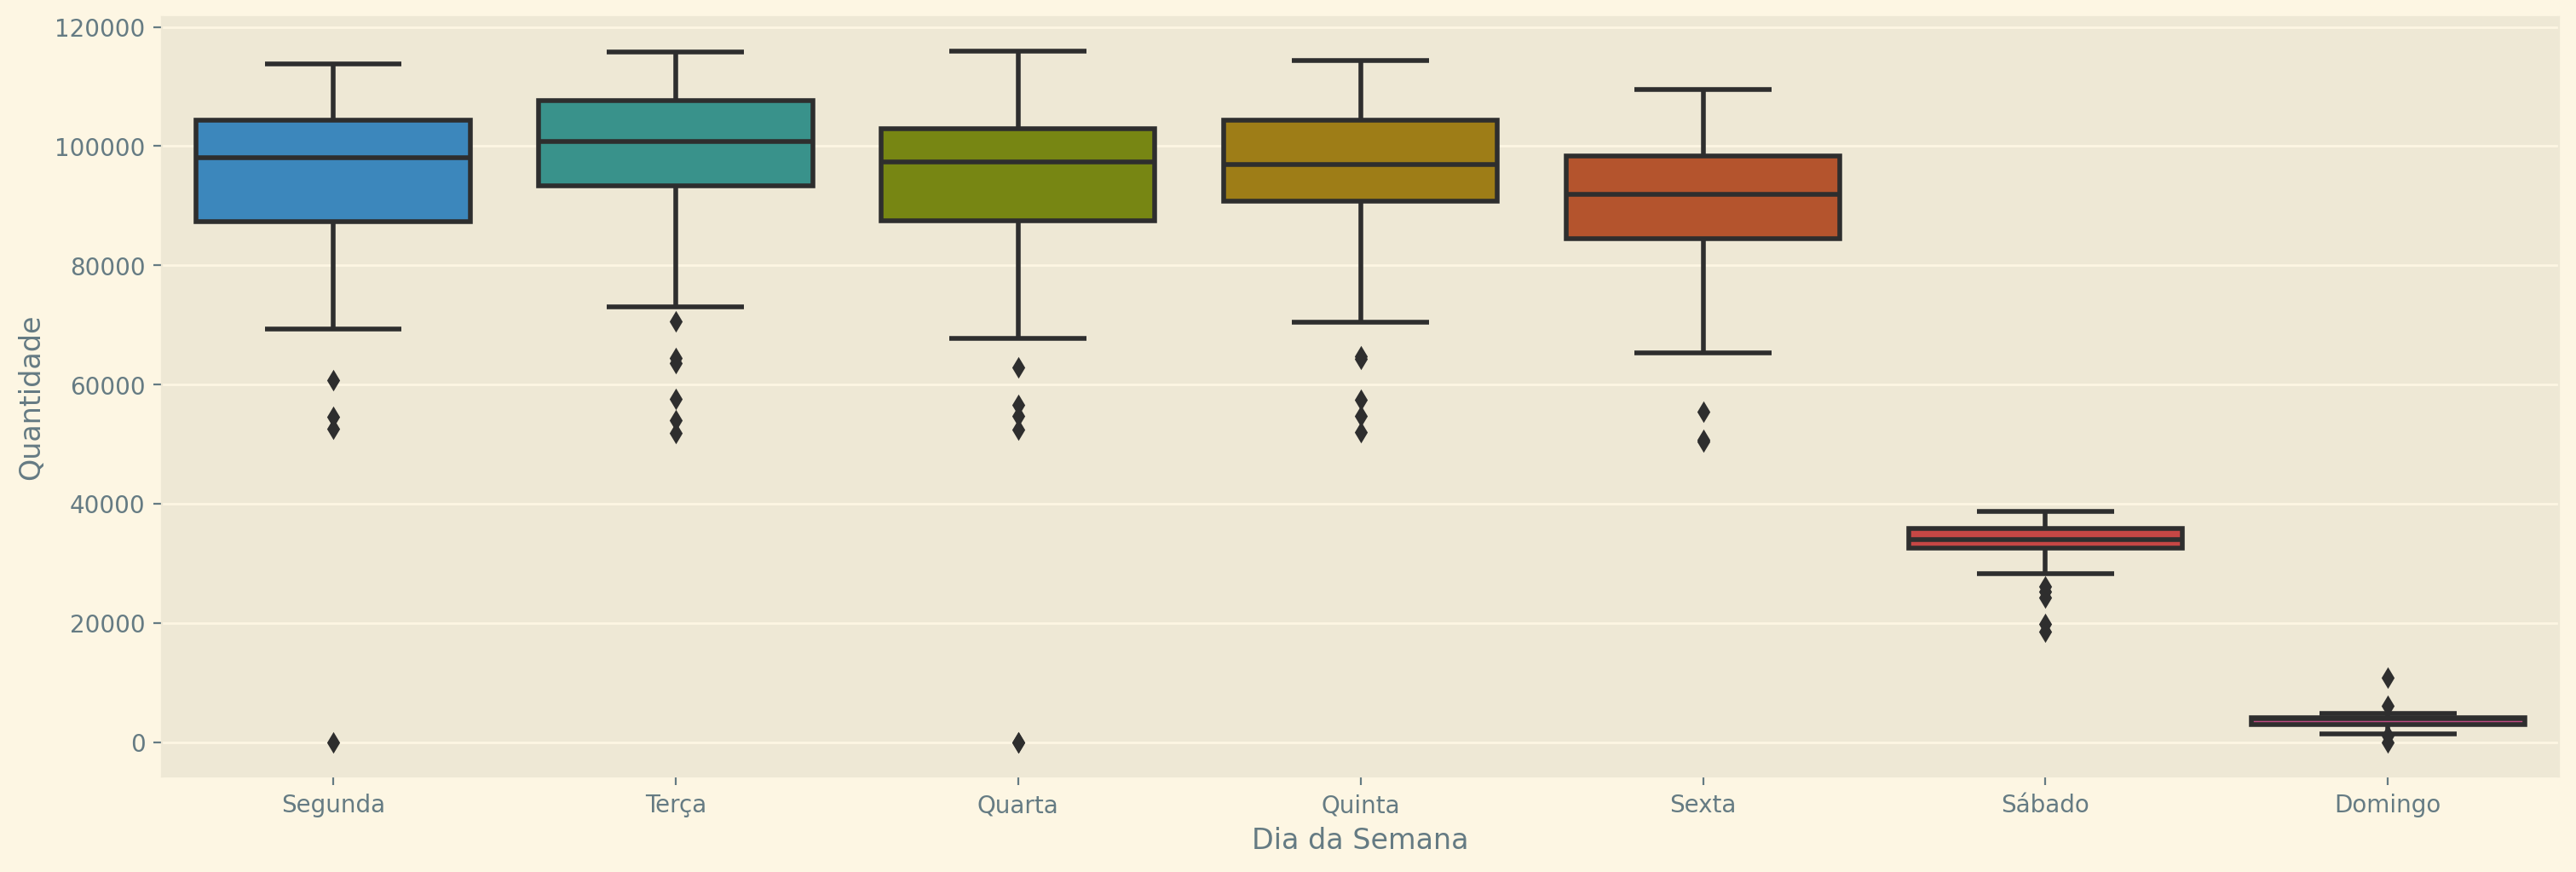

In [12]:
# refazendo o boxplot para analisar se foram retirados os otlines

box_correct = box_day(freq_pas)
box_correct

Percebe-se que existem valores zerados para segunda e quarta. Isto ocorre pelo fato de limitarmos a correção até o mês setembro. Iremos construir os modelo de previsão para o último mês da série histórica, outubro, dessa forma, deixou-se inalterado o mês final.

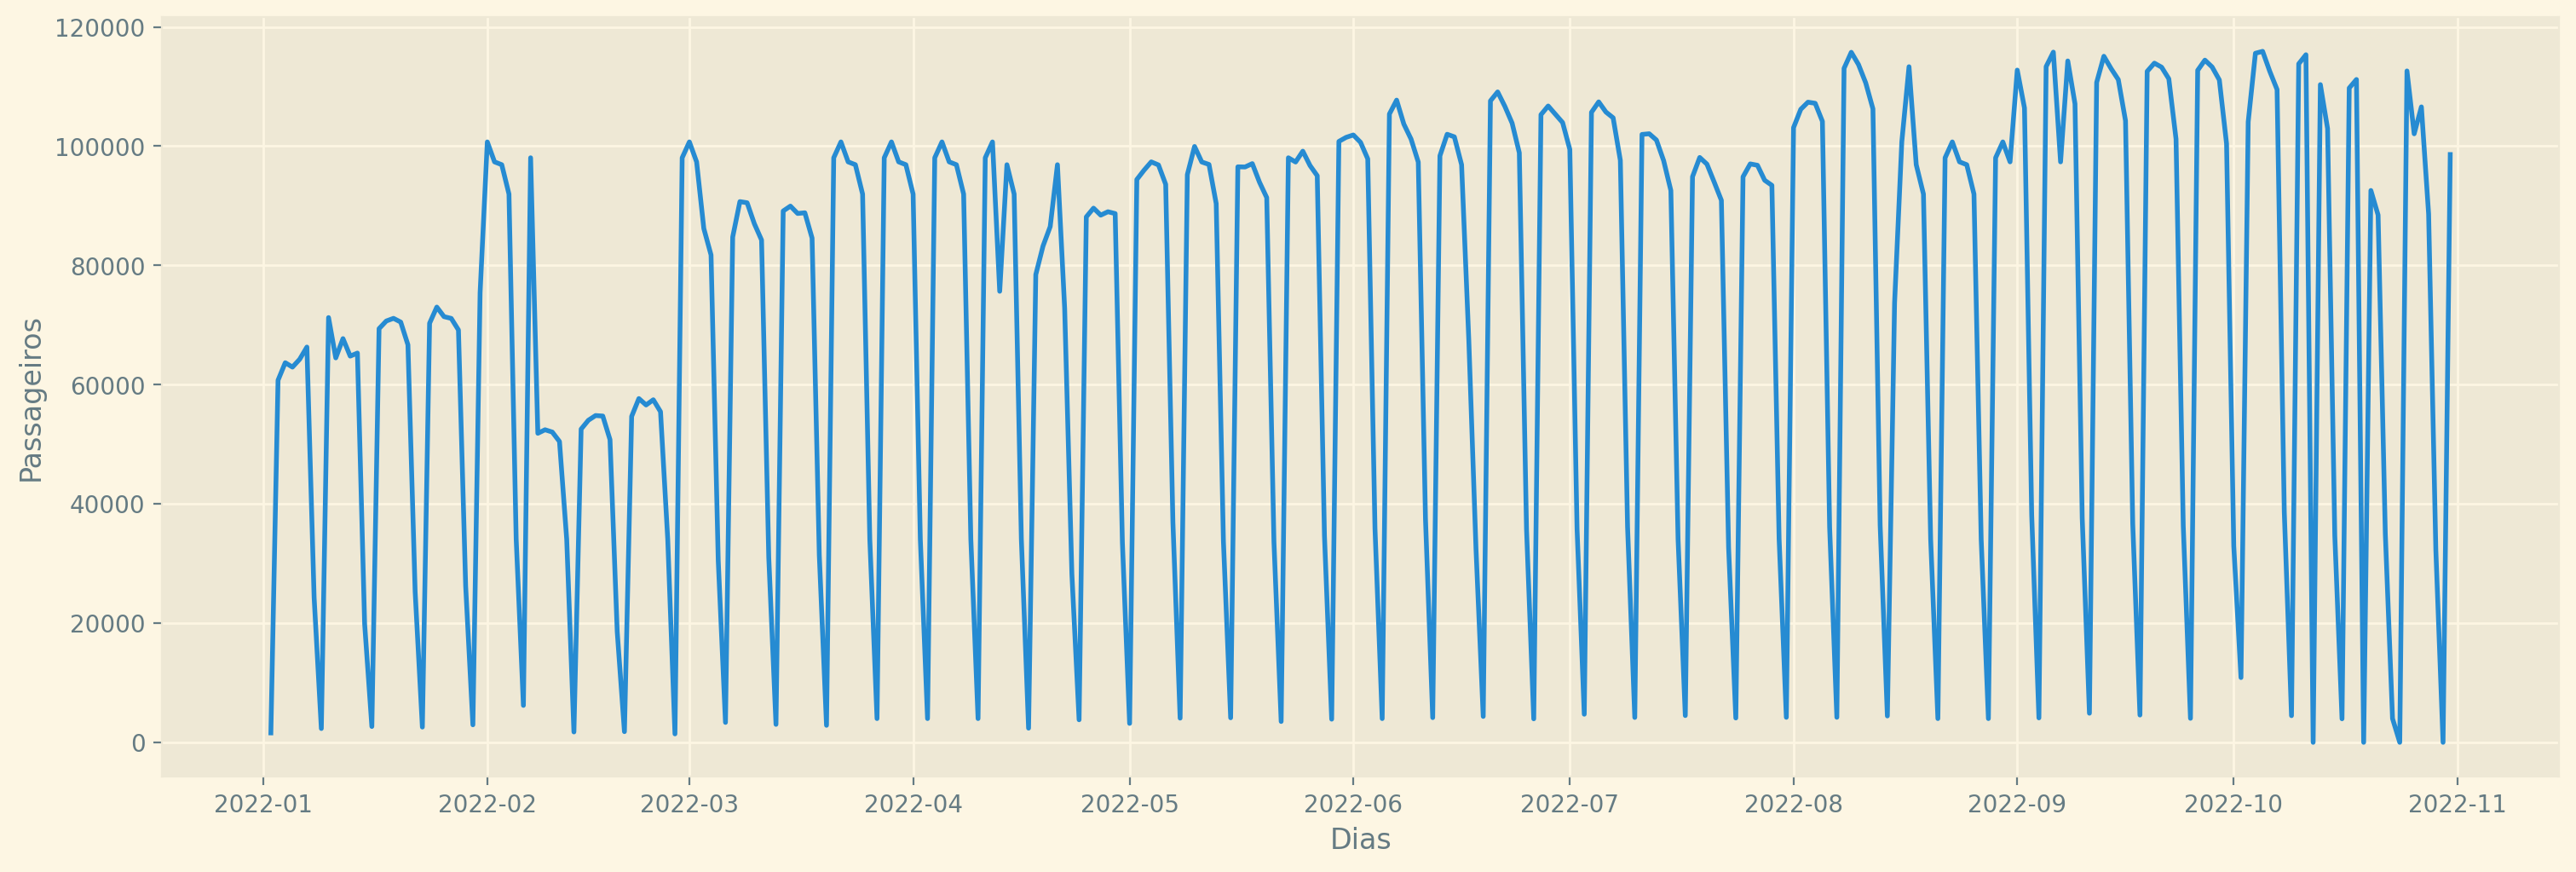

In [13]:
# gráfico com a vizualização da linha do tempo de 2022 com as data corrigidas 
plot_ts()

Podemos perceber que na série original que na parte final do período analisado, referente ao mês de outubro, há um comportamento  atípico e sem o padrão configurado as datas anteriores. Devido as eleições e número de feriados, o compotarmento da série é alterado o que resulta em valores de erros maiores. 

Para os modelos de previsão, iremos utilizar a série corrigida que ainda apresenta um comportamento influenciado pelas oscilações não previstas, só que em um grau menor, todavia, após um período mensal, é importante realizar a construção de outro modelo de previsão da série e avaliar as mundanças no modelo criado.

Outro processo futuro é a acompanhar a estabilização da frequência de passageiros. Podemos ver no gráfico que há uma diferença nos valores de passageiros comparando primeiro e segundo semestre, resultado de um aumento de pessoas transportadas. No segundo semestre, os passageiros, em dias úteis superam os 100 mil, todavia, esse comportamento só se estabilizou em maio e ocorreu outro incremento a partir de agosto, onde os valores se aproximam dos 120 mil passageiros. 

# Previsão de passageiros

## Séries Temporais

Com a correção da série de passageiros, podemos realizar um modelo de previsão para o transporte público de Teresina. Para isto, iremos utilizar, numa primeira análise, com séries temporais, o modelo Arima com Sazonalidade, SARIMA.

Para séries temporais, o processo é um pouco exigente devido a existência de pressupostos para a criação de modelos de previsão utlizando ARIMA. Temos que testar a série em relação a sua estacionariedade (média constante e dependência da função de autocovariância dependente somente do tempo). Pelo comportamento do gráfico, fica claro que existe a sazonalidade, direcionando para o uso de um modelo SARIMA. 

Iremos realizar os testes para verificar a cumprimento dos pressupostos e, caso não seja cumprido, iremos realizar a diferença ($X_{t} - X_{t-1}$), para conseguir deixar a série estacionária

Uma das abordagens de séries temporais é que podemos realizar a divisão da série temporal em três elementos:

- Tendência
- Sazonalidade
- Erro

Tendência consiste no comportamento puro da série e conseguimos enxergar a direção que a série segue, podendo ser de alta, baixa ou de estabilidade

Sazonalidade indica a repetição do processo em relação ao seu funcionamento, após uma quantidade t de períodos, a série repete seu comportamento. 

Os erros são os movimentos que não são captados nos pela tendência e pela sazonalidade. Consiste no aspecto aletório da séries.

No gráfico abaixo, o comportamento da série e as três partes isoladas.

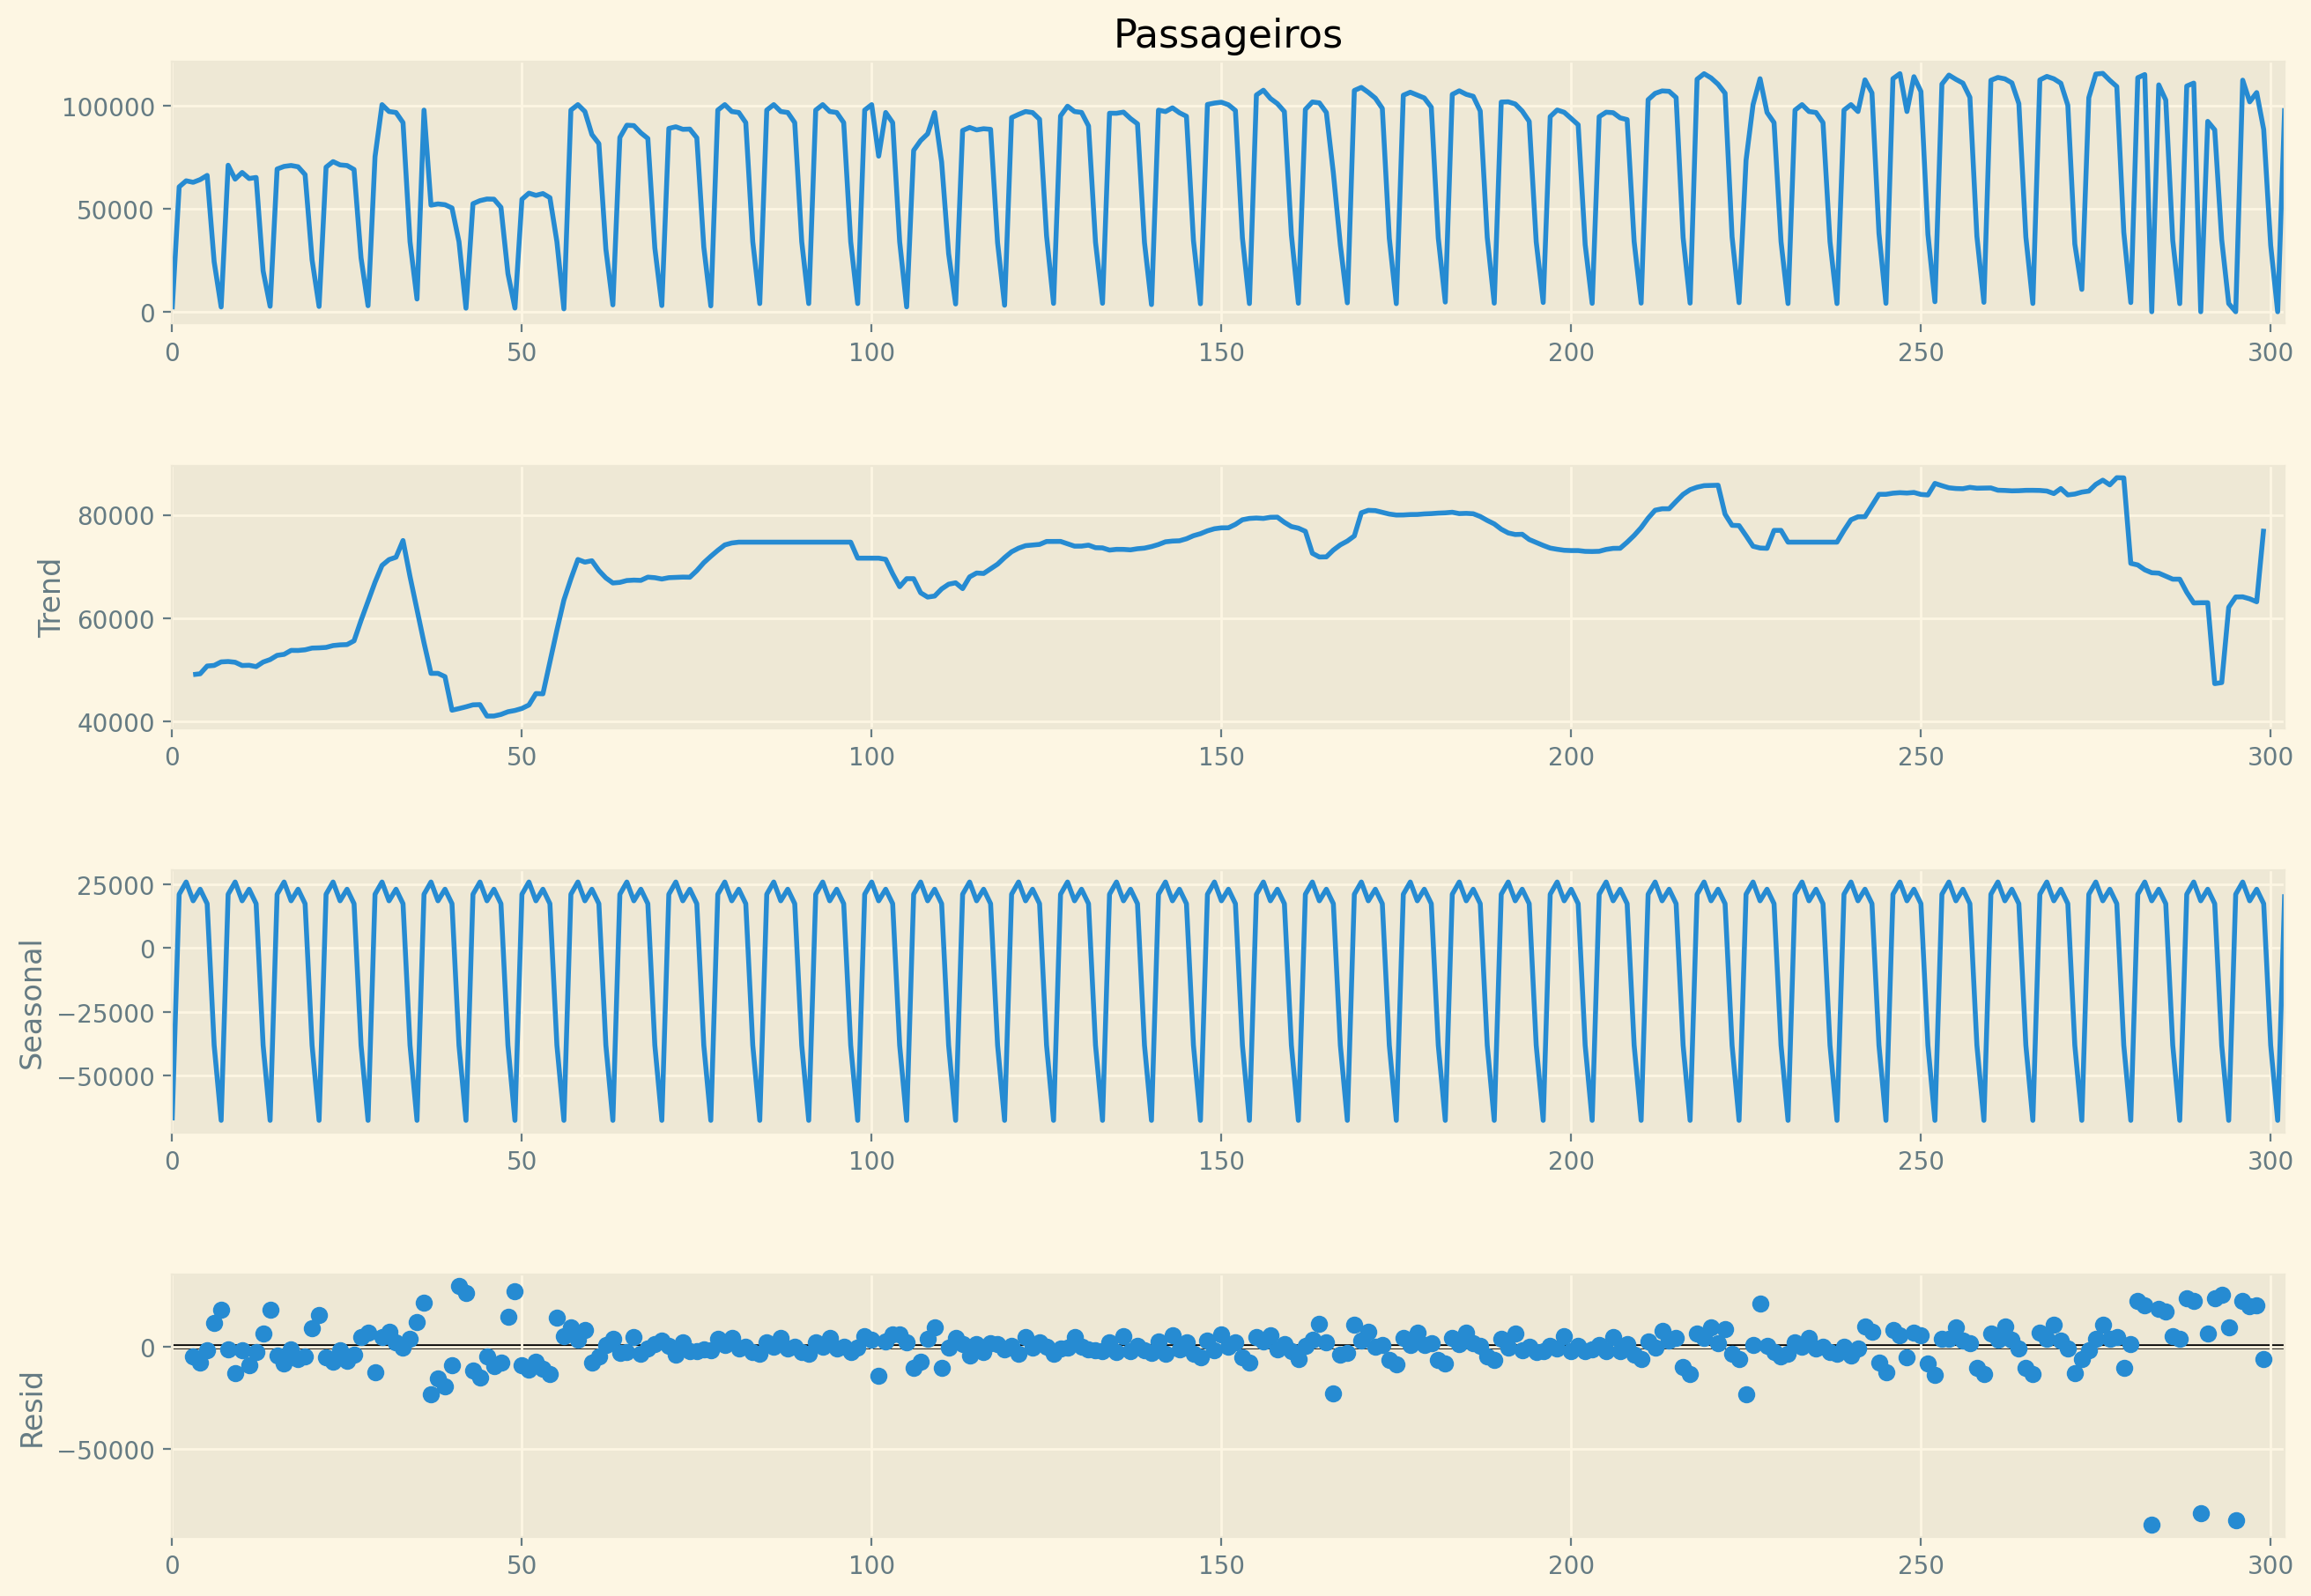

In [14]:
result = seasonal_decompose(freq_pas['Passageiros'], period = 7,  model='additive')
fig = result.plot()
fig.set_size_inches(15,10)
fig.show()

Após identificar os componentes da série, podemos realizar o teste de estacionariedade para descobrimos se iremos precisar de alguma transformação para possibilitar a criação do modelo.

A função abaixo foi adaptada para nosso trabalho e auxilia na análise. No teste de Fuller, com intervalo de confiança de 95%, o p-valor menor que 0,05 indica a série estacionária. 

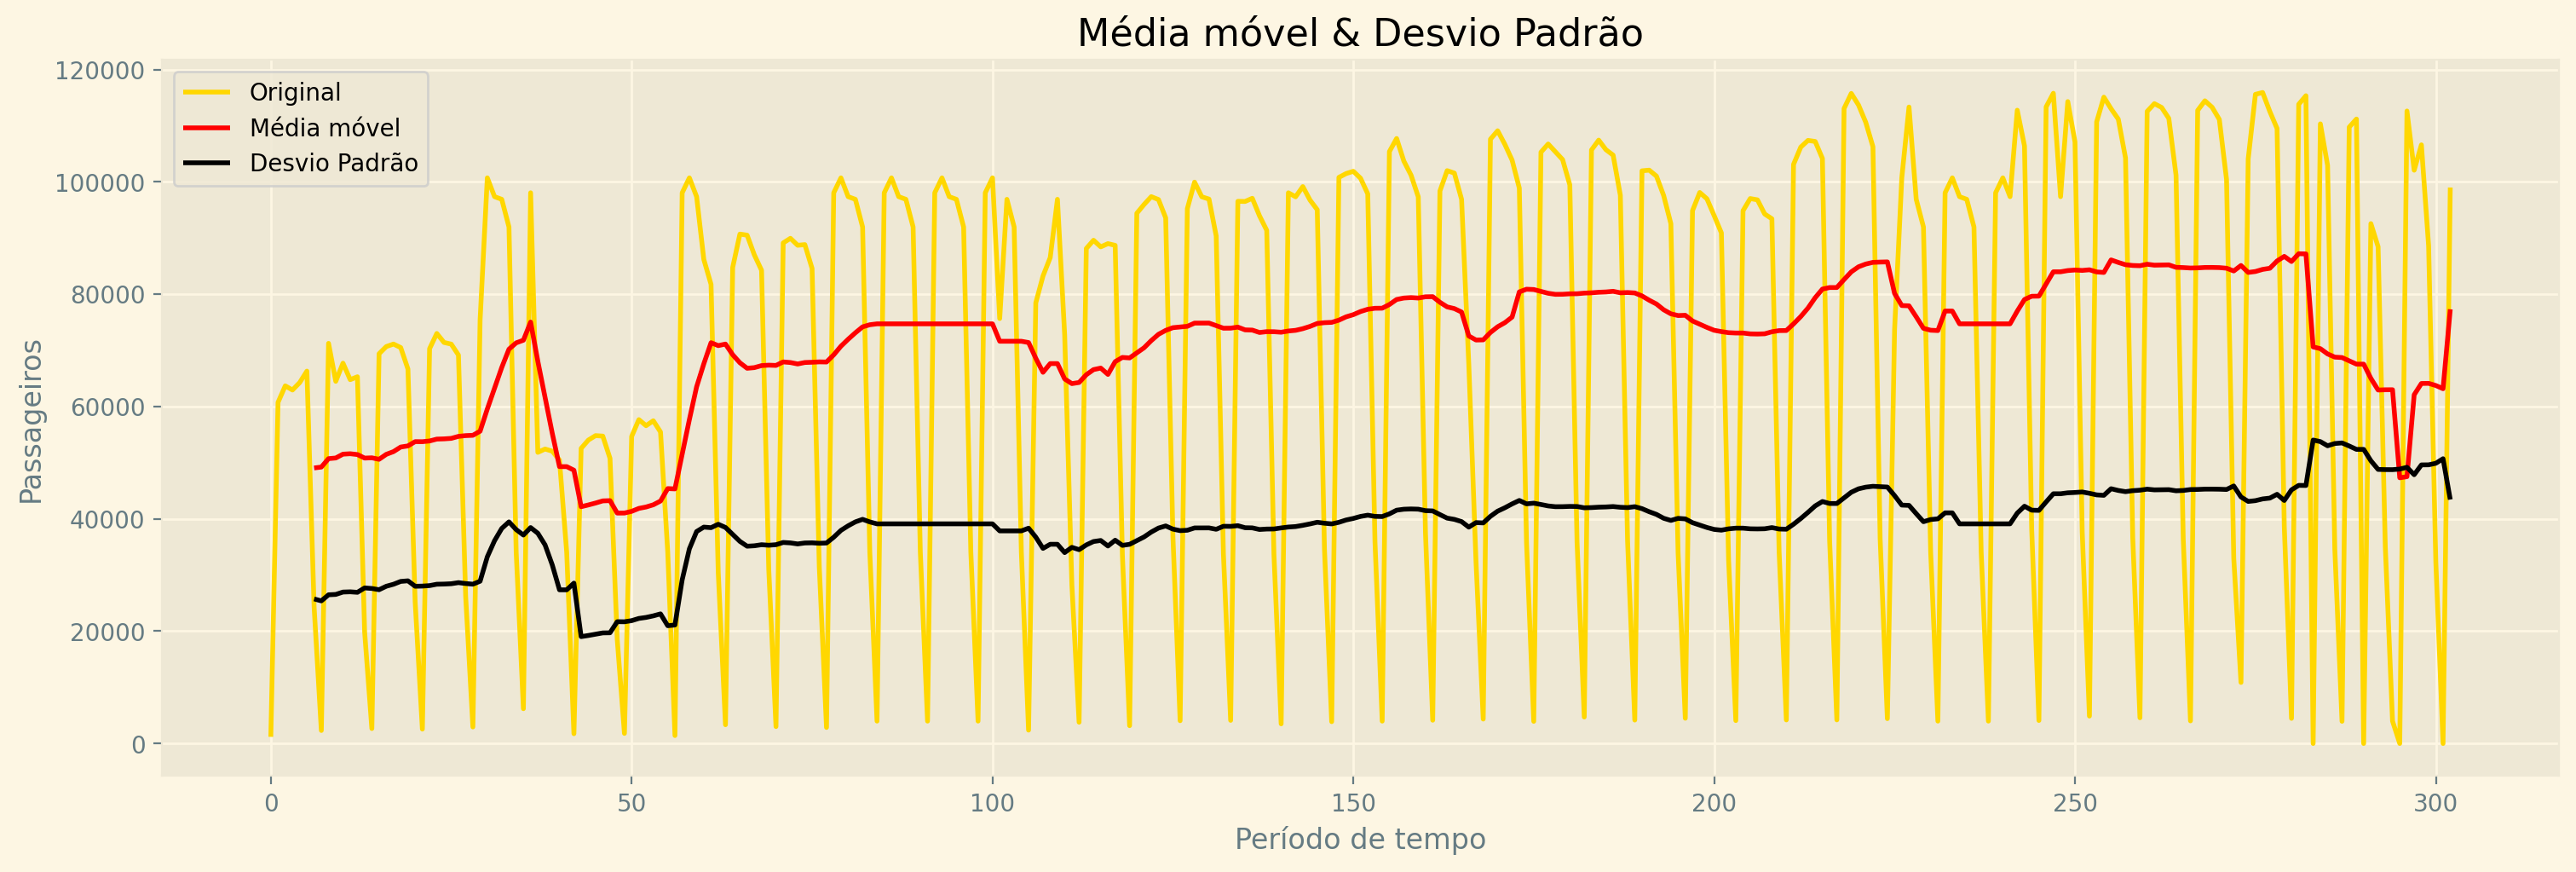

Test Statistic                  -2.689000
p-value                          0.075961
#Lags Used                      14.000000
Number of Observations Used    288.000000
Critical Value (1%)             -3.453262
Critical Value (5%)             -2.871628
Critical Value (10%)            -2.572146
dtype: float64


In [15]:

# Função baseada no código em: https://medium.com/@stallonejacob/time-series-forecast-a-basic-introduction-using-python-414fcb963000

def test_stationarity(timeseries, t):

    rolmean = timeseries.rolling(t).mean()
    rolstd = timeseries.rolling(t).std()

#Plot rolling statistics:
    fig, ax = plt.subplots(constrained_layout=True)
    fig.set_size_inches(15,5)
    plt.plot(timeseries, color='gold',label='Original')
    plt.plot(rolmean, color='red', label='Média móvel')
    plt.plot(rolstd, color='black', label = 'Desvio Padrão')
    plt.legend(loc='best')
    plt.title('Média móvel & Desvio Padrão')
    plt.xlabel("Período de tempo")
    plt.ylabel('Passageiros')
    plt.show()
    #Perform Dickey-Fuller test:
    #print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(freq_pas['Passageiros'],7)

Concluímos ao nível de 95% que a série é estacionária e não precisaremos realizar nenhuma transformação para deixar para deixar a série adequada ao presuposto da estaciónariedade.

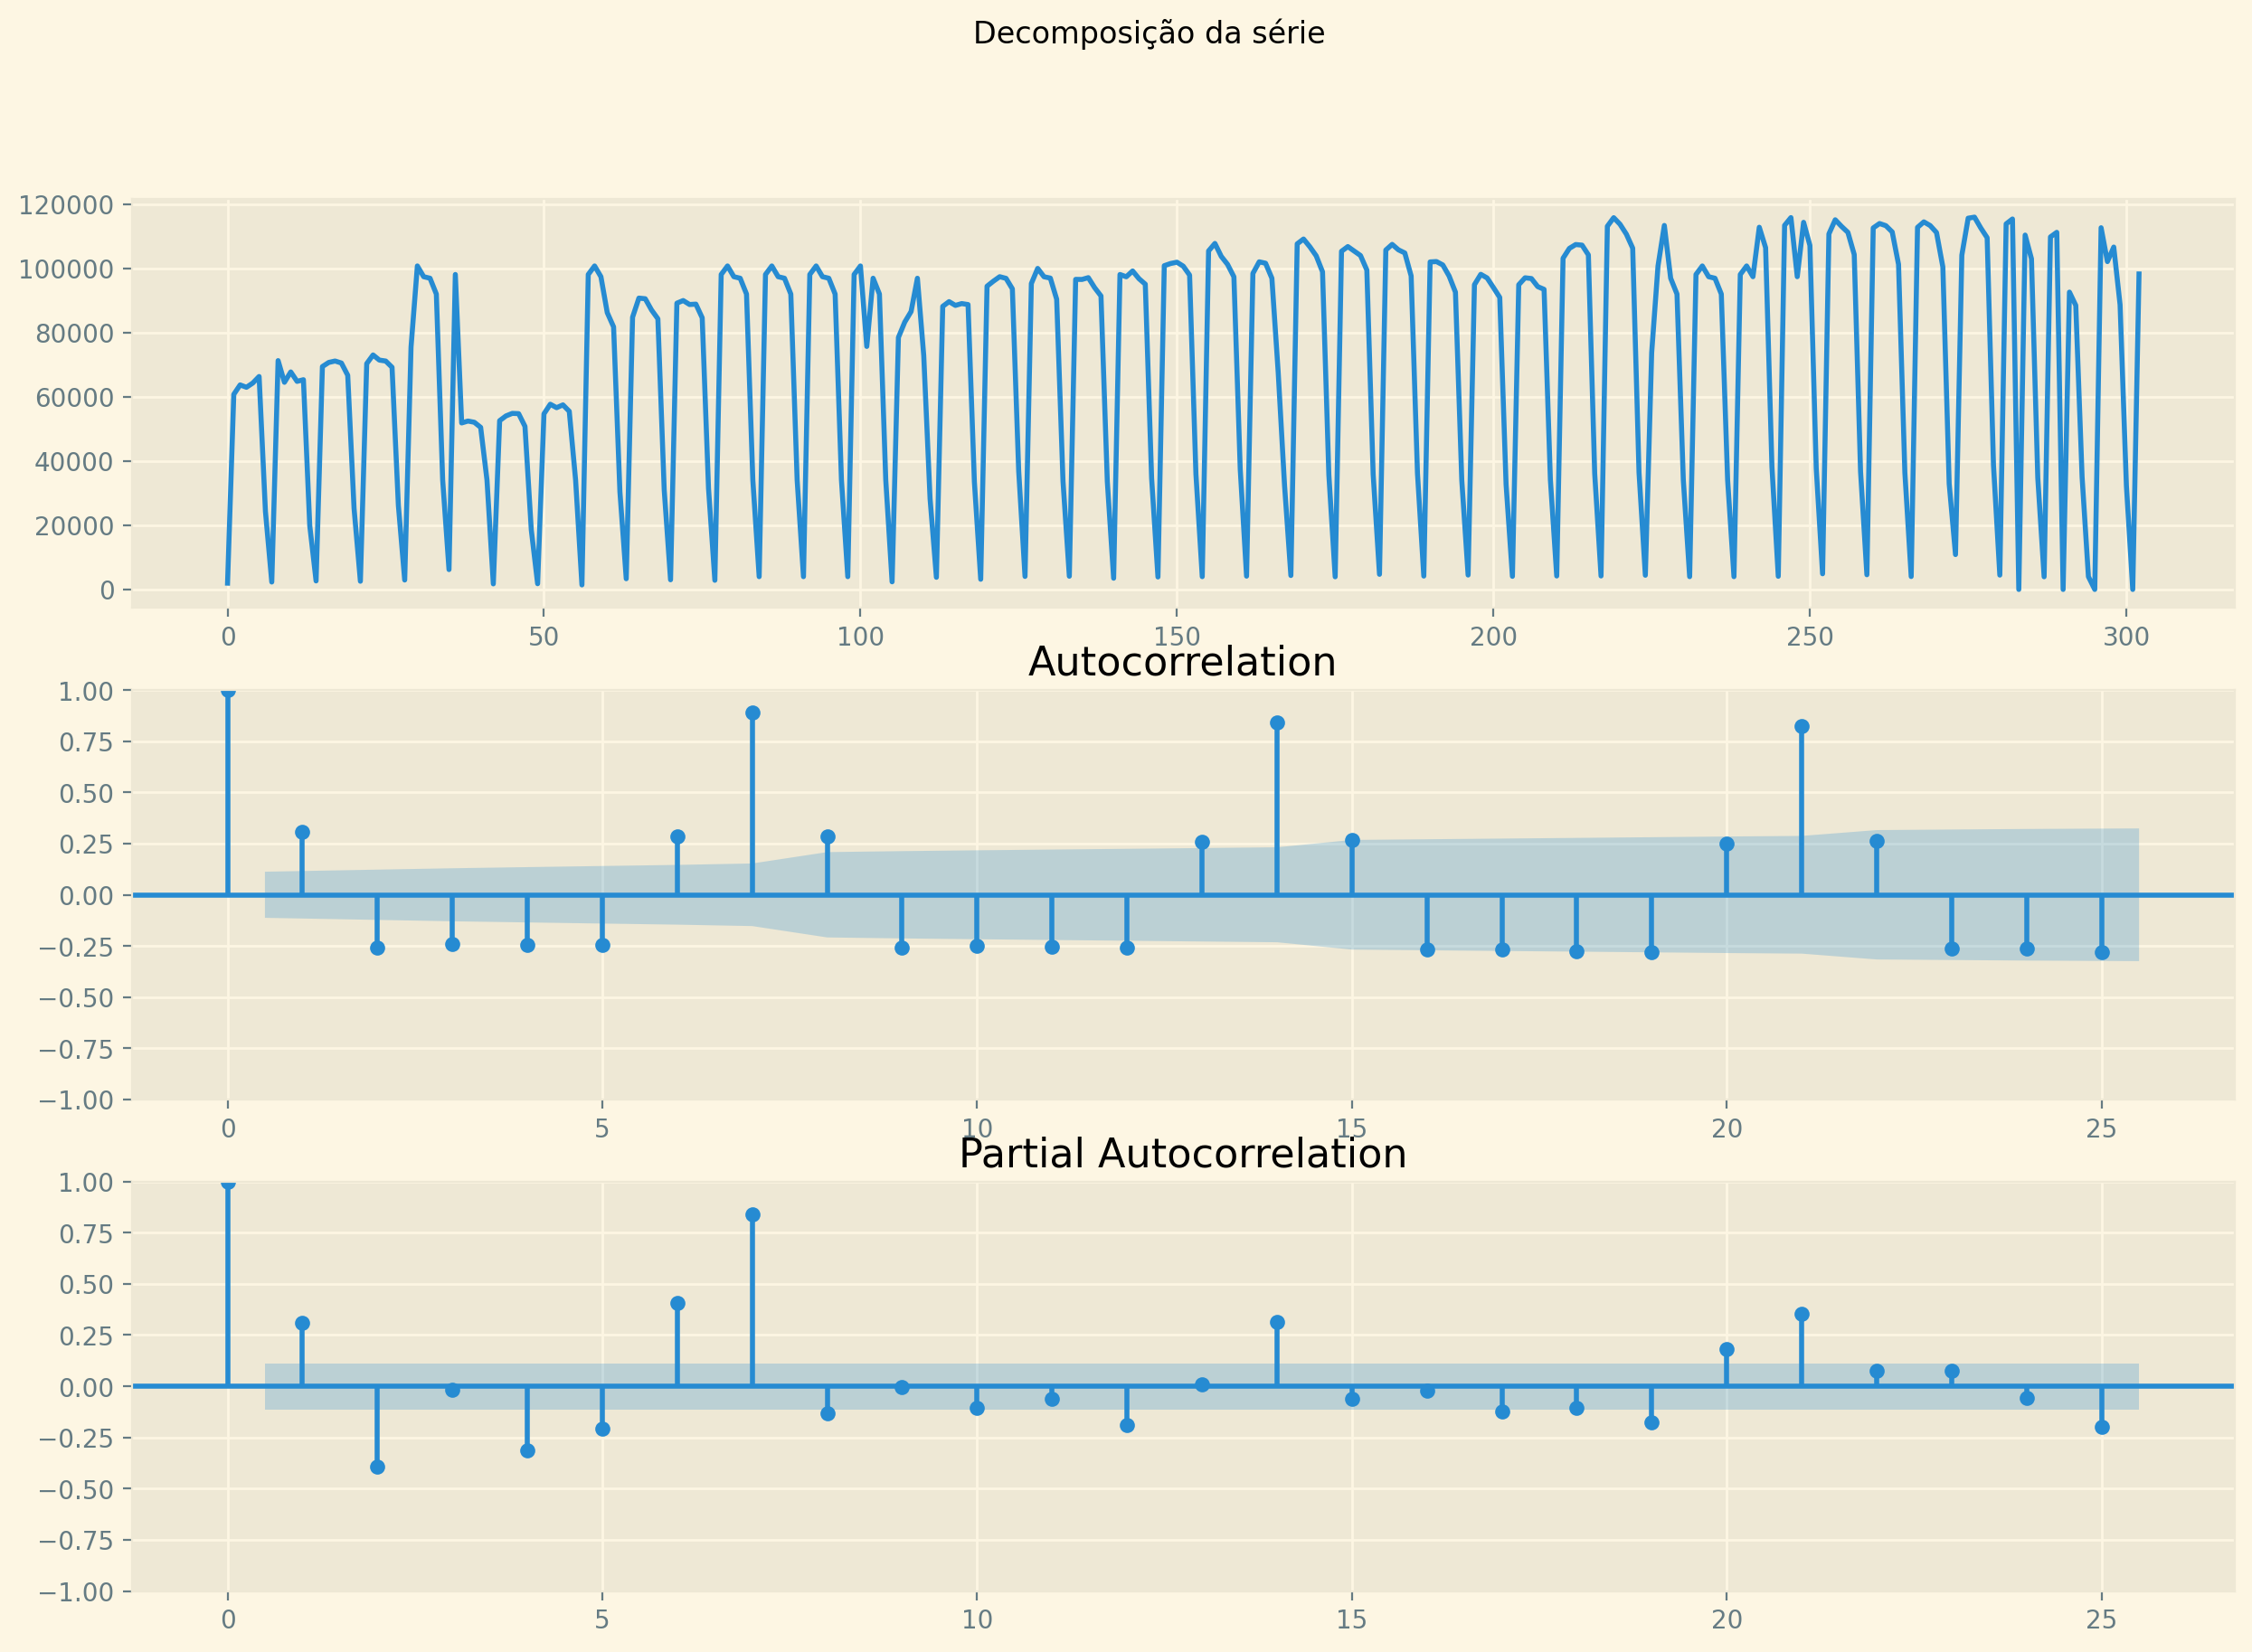

In [16]:


def graficos_series():
    fig, (ax1, ax2, ax3) = plt.subplots(3)
    fig.suptitle("Decomposição da série")
    fig.set_size_inches(15,10)
    ax1.plot(freq_pas['Passageiros'])
    plot_acf(freq_pas['Passageiros'], ax = ax2)
    plot_pacf(freq_pas['Passageiros'], ax = ax3)
    plt.show()

graficos_series()

O gráficos não permitem um diagnóstico claro de qual modelos podemos utilizar para séries temporais. Para auxíliar, iremos utilizar a função auto-arima para testar vários modelos e realizamos uma divisão em 90% para treino e 10% para teste, correspondendo ao último mês série histórica utilizada. A mesma divisão será utilizada para Redes Neurais para podermos comparar os resultados.

Abaixo, temos o procedimento de divisão da série aplicação da função auto-arima

In [17]:

data = freq_pas['Passageiros']
test_size = int(0.1 * len(data))
Y_train, y_test = data[:-test_size], data[-test_size:]
X_train, x_test = np.arange(Y_train.shape[0]), np.arange(Y_train.shape[0], data.shape[0])
X_train.shape, Y_train.shape, y_test.shape, x_test.shape

((273,), (273,), (30,), (30,))

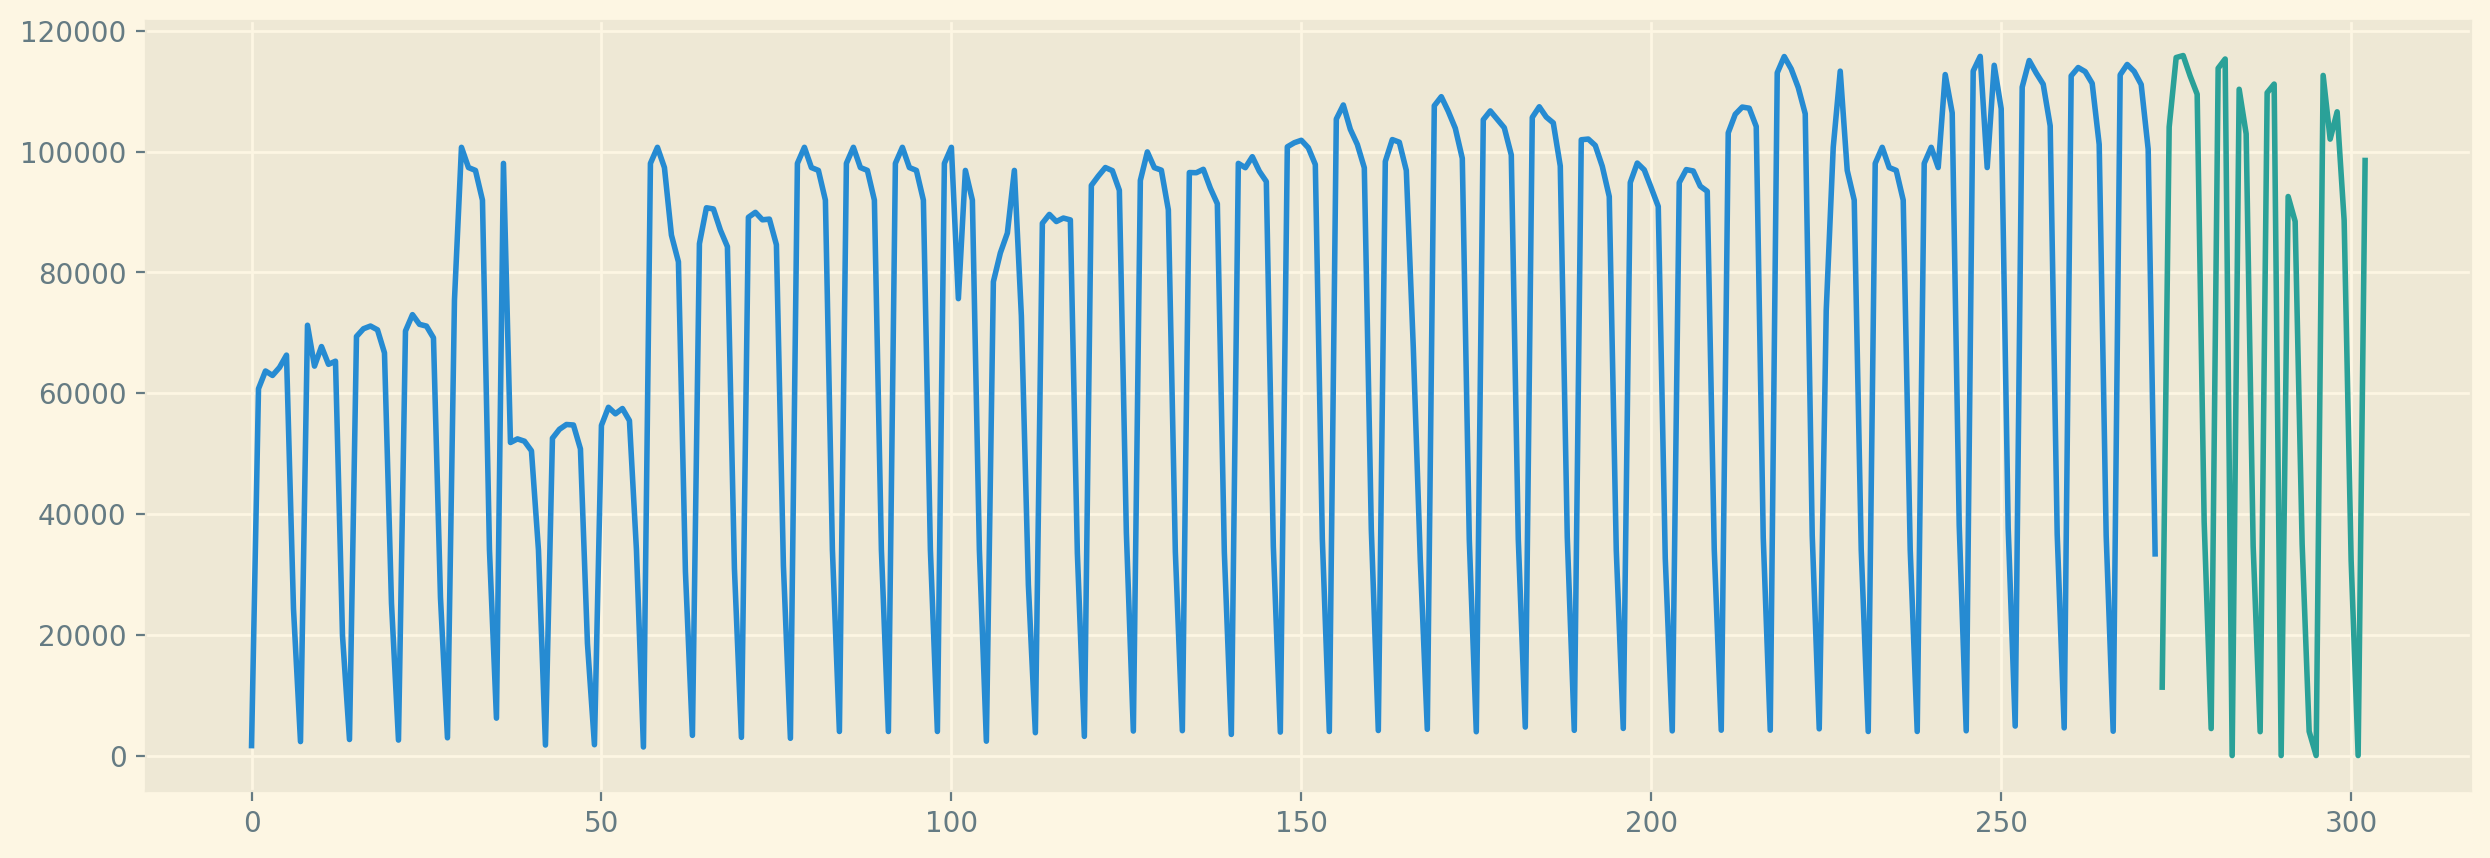

In [18]:
def plot_ts2():
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    ax.plot(X_train, Y_train)
    ax.plot(x_test, y_test)

plot_ts2()

In [19]:
model_auto = pm.auto_arima(Y_train, start_p=1, start_q=1,
                    #   exogenous=df[['seasonal_index']],
                      test='adf',
                      max_p=7, max_q=7,
                      m=7,             
                      d=1,          
                      seasonal=True,   
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=5563.742, Time=0.39 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=5668.212, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=5604.093, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=5556.000, Time=0.46 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=5634.709, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=5570.426, Time=0.18 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=5570.453, Time=0.16 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=5587.980, Time=0.15 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=5572.425, Time=1.37 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=5589.169, Time=0.17 sec
 ARIMA(0,1,2)(0,1,1)[7]             : AIC=5562.641, Time=0.35 sec
 ARIMA(1,1,0)(0,1,1)[7]             : AIC=5583.181, Time=0.19 sec
 ARIMA(1,1,2)(0,1,1)[7]             : AIC=5564.033, Time=0.54 sec
 ARIMA(0,1,1)(0,1,1)[7] intercept   : AIC=5557.887, Time=0.79 sec

Best model:  ARIMA(0,1,1)(0,1,1)

In [20]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  273
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 7)   Log Likelihood               -2775.000
Date:                           Thu, 22 Jun 2023   AIC                           5556.000
Time:                                   12:28:16   BIC                           5566.739
Sample:                                        0   HQIC                          5560.315
                                           - 273                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4583      0.034    -13.434      0.000      -0.525      -0.391
ma.S.L7       -0.6198      0.029    -21.564      0.000      -0.676      -0.563
sigma2      7.243e+07   1.56e-10   4.65e+17      0.000    7.24e+07    7.24e+07
===================================================================================
Ljung-Box (L1) (Q):                   3.60   Jarque-Bera (JB):               422.23
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               0.32   Skew:                            -0.78
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.99e+32. Standard errors may be unstable.
"""

No gráfico abaixo temos a comparação com o período de teste e consiste na raiz quadrática do erro médio

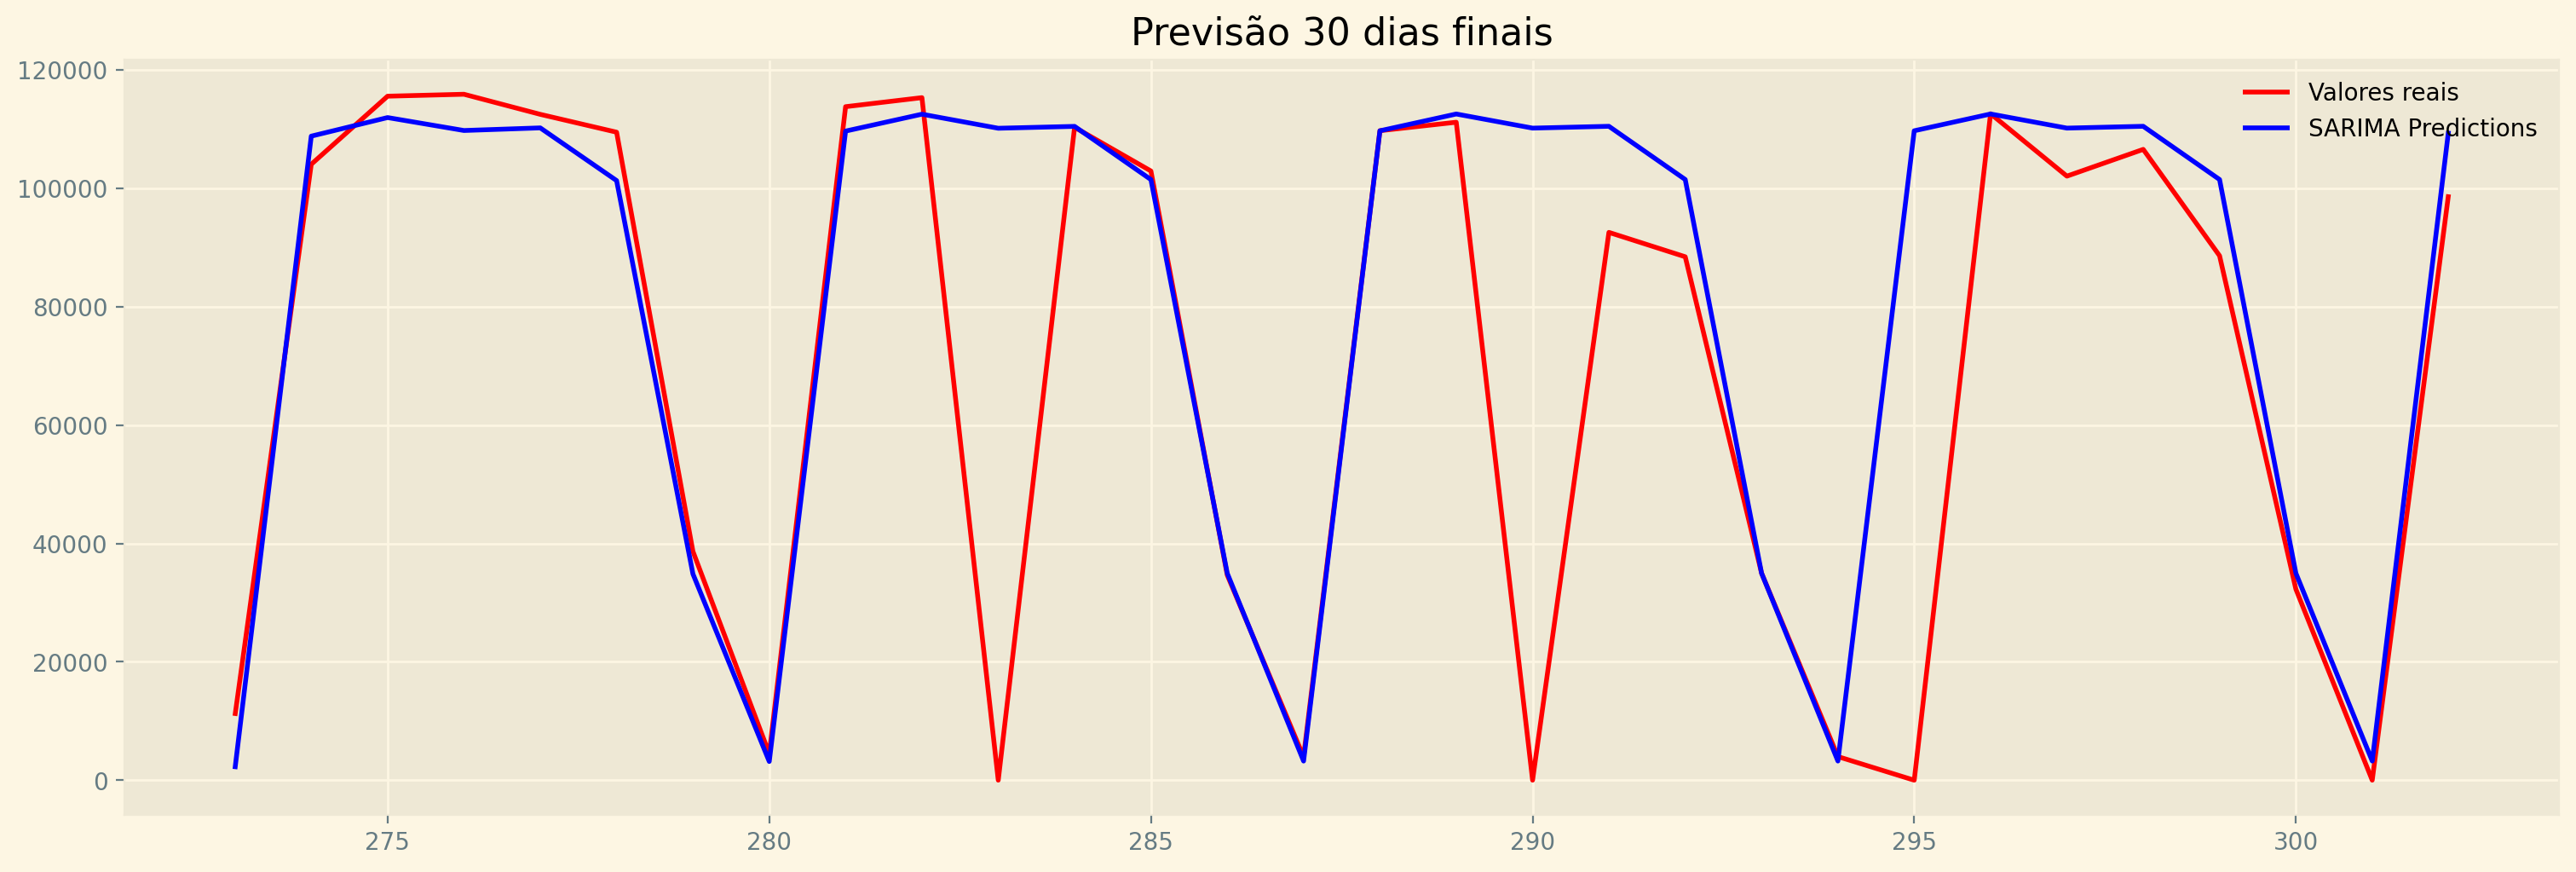

RMSE: 35336.50


In [23]:
model_sarima = SARIMAX(Y_train, model =  model_auto.order, seasonal_order = model_auto.seasonal_order)
model_sarima = model_sarima.fit()


def pred_sarima():
    y_pred = model_sarima.get_forecast(len(y_test.index))
    y_pred_df = y_pred.conf_int(alpha = 0.05)
    y_pred_df['Predictions'] = model_sarima.predict(start = y_pred_df.index[0], 
                                                    end = y_pred_df.index[-1])
    y_pred_df.index = y_test.index
    y_pred_out = y_pred_df["Predictions"] 
    fig, ax = plt.subplots(constrained_layout=True)
    fig.set_size_inches(15, 5)
    plt.plot(y_test, color = "red", label = 'Valores reais')
    plt.plot(y_pred_out, color='Blue', label = 'SARIMA Predictions')
    plt.legend(loc='upper right', frameon=False)
    plt.title('Previsão 30 dias finais')
    plt.show()
    testScore1 = mean_squared_error(y_test, y_pred_out, squared = False)
    print('RMSE: %.2f' % (testScore1))

pred_sarima()


Percebe-se que a série consegue acompanhar bem os valores reais, menos os valores zerados, mas é uma situação esperada. 

Iremos utilizar outro método, mais recente e originado em redes neurais  para comparação

# Rede Neurais

Quando procuramos  criar um modelo de predição para séries temporais, temos uma diferença importante com  base em redes neurais. Não há necessidade de analisar se a série é estacioária. Métodos de marchine lerning conseguem trabalhar com dados não-paramétricos o que possibilita a utilização da série sem nenhuma alteração. A única mundança consiste em avaliar dias faltantes devido a greve e criar a linha histórica com dias zerados. 

O maior problema ao utilizar métodos algébricos é na quantidade de opções, o que é um problema bom, mas exigirá mais atenção para encontrar o melhor método. 

Para este trabalho, iremos utilizar LTSM, que consiste numa variação do modelo de Rede Neural, do tipo recorrente e consiste em um processo um pouco mais complexo, pois envolve a inclusão de elementos de "memorização" on interior das redes Neurais. Resumidamente, elementos de aproveitamento e descarte de informações são incluídas no interior da Rede Neural para aprendizagem da sequência em análise, como um série temporal. O algoritmo segue abaixo:

In [22]:
torch.manual_seed(42)

class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.hidden_size = 32
        self.lstm = nn.LSTM(input_size=1, hidden_size=32, batch_first=True)
        self.fc = nn.Linear(32, 1)
        
    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)
        x = x.view(batch_size, seq_len, -1)  
        _, (h_n, _) = self.lstm(x)
        out = self.fc(h_n[-1])
        return out


def train(model, train_data):
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()

    n_epochs = 1000
    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()
        
        inputs, targets = train_data
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()
        
        if (epoch+1) % 10 == 0:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, n_epochs, loss.item()))


timeseries = freq_pas[['Passageiros']].values.astype('float32')

# train-test split for time series
train_data, test_data = timeseries[test_size:], timeseries[:test_size]

def create_dataset(data, lookback):
    X, y = [], []
    for i in range(len(data)-lookback):
        X.append(data[i:i+lookback])
        y.append(data[i+1:i+lookback+1])
    X = torch.tensor(X).unsqueeze(2).float()
    y = torch.tensor(y).unsqueeze(2).float()
    return X, y

lookback = 7
Xt_train, yt_train = create_dataset(train_data, lookback)
Xt_test, yt_test = create_dataset(test_data, lookback)

model = LSTMModel()
train(model, (Xt_train, yt_train))

model.eval()
with torch.no_grad():
    test_inputs = Xt_test
    test_outputs = model(test_inputs)
    test_loss = nn.MSELoss()(test_outputs, yt_test)
    rmse = torch.sqrt(test_loss)  # Calculate RMSE
    print('Test Loss: {:.4f}'.format(test_loss.item()))
    print('RMSE: {:.4f}'.format(rmse.item()))

Epoch [10/1000], Loss: 6821102080.0000
Epoch [20/1000], Loss: 6821024768.0000
Epoch [30/1000], Loss: 6820944896.0000
Epoch [40/1000], Loss: 6820815872.0000
Epoch [50/1000], Loss: 6820713984.0000
Epoch [60/1000], Loss: 6820612096.0000
Epoch [70/1000], Loss: 6820511744.0000
Epoch [80/1000], Loss: 6820411392.0000
Epoch [90/1000], Loss: 6820313088.0000
Epoch [100/1000], Loss: 6820214272.0000
Epoch [110/1000], Loss: 6820117504.0000
Epoch [120/1000], Loss: 6820019712.0000
Epoch [130/1000], Loss: 6819923968.0000
Epoch [140/1000], Loss: 6819827712.0000
Epoch [150/1000], Loss: 6819730944.0000
Epoch [160/1000], Loss: 6819635200.0000
Epoch [170/1000], Loss: 6819540480.0000
Epoch [180/1000], Loss: 6819443712.0000
Epoch [190/1000], Loss: 6819335680.0000
Epoch [200/1000], Loss: 6819237888.0000
Epoch [210/1000], Loss: 6819142656.0000
Epoch [220/1000], Loss: 6819045888.0000
Epoch [230/1000], Loss: 6818948608.0000
Epoch [240/1000], Loss: 6818852352.0000
Epoch [250/1000], Loss: 6818756608.0000
Epoch [26

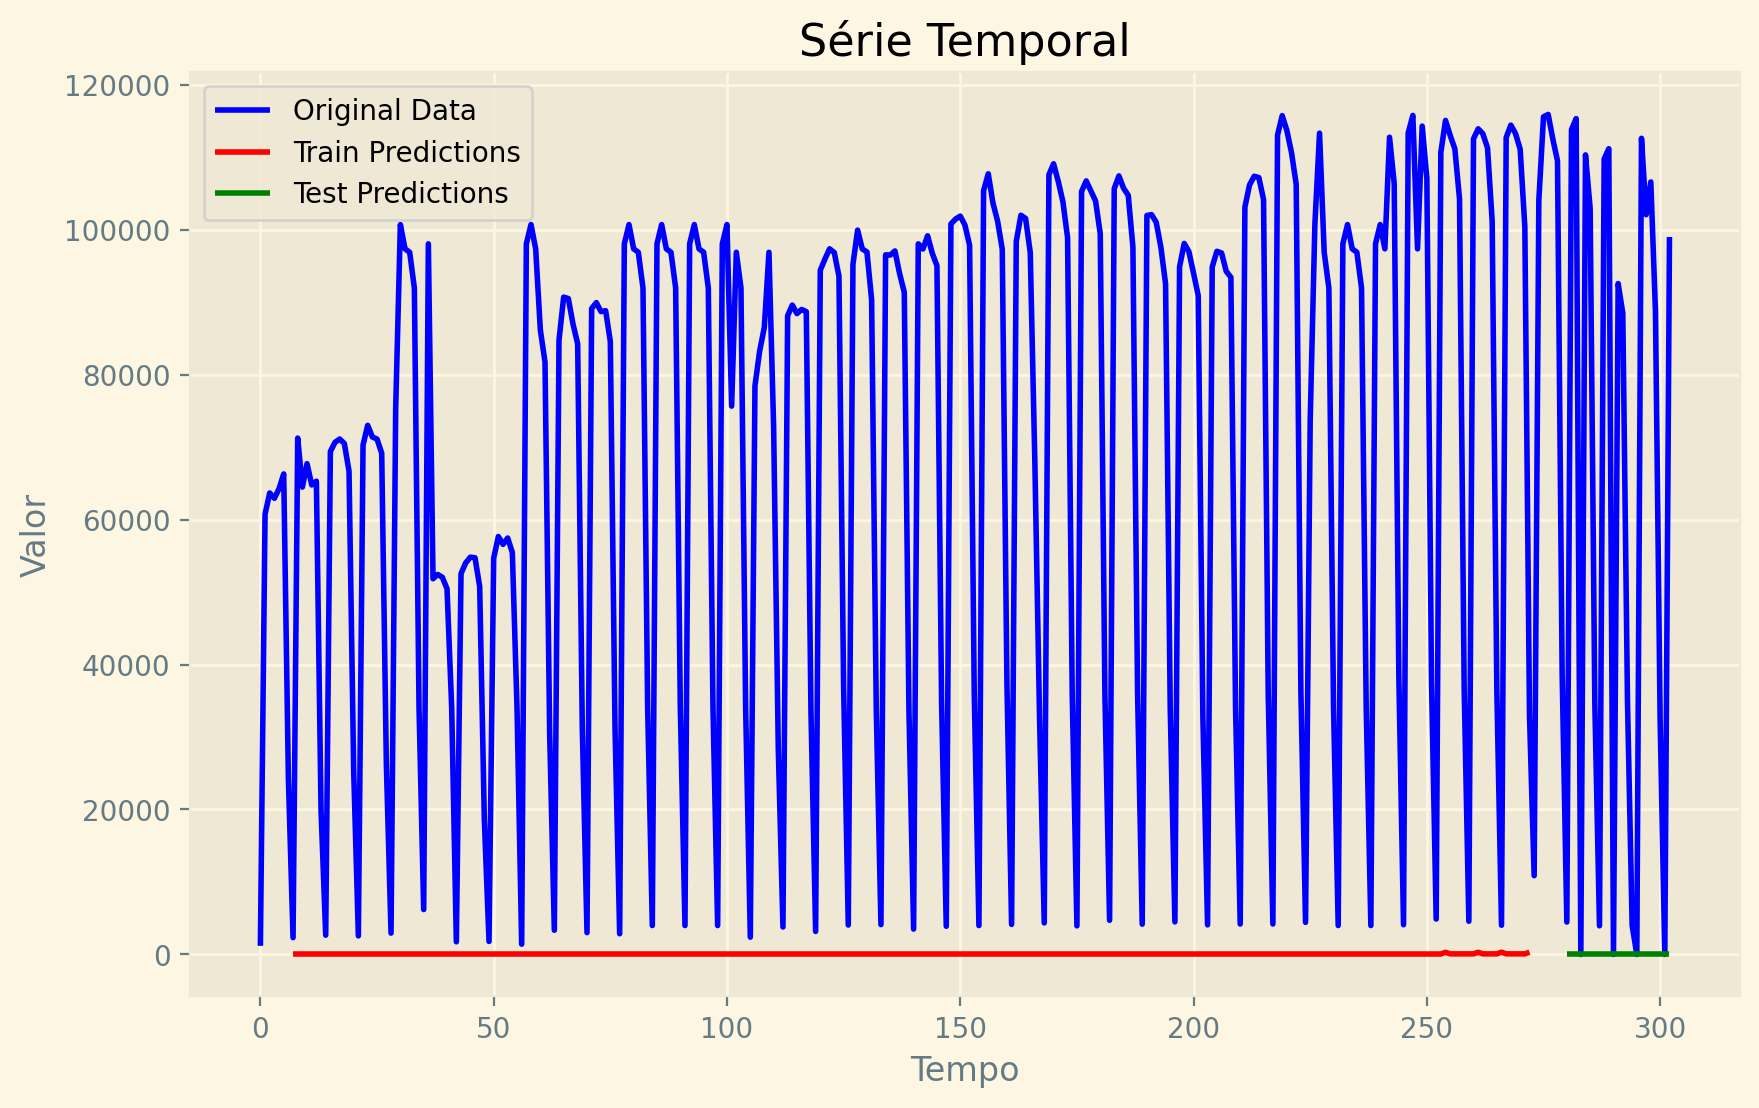

In [34]:
def pred_neural():
    with torch.no_grad():
        # Shift train predictions for plotting
        train_size = len(timeseries) - test_size
        train_plot = np.ones_like(timeseries) * np.nan
        train_plot[lookback:train_size, 0] = model(Xt_train)[:, -1].flatten().numpy()
        
        # Shift test predictions for plotting
        test_plot = np.ones_like(timeseries) * np.nan
        test_plot[train_size+lookback:len(timeseries), 0] = model(Xt_test)[:, -1].flatten().numpy()

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(timeseries, c='b', label='Original Data')
    plt.plot(train_plot, c='r', label='Train Predictions')
    plt.plot(test_plot, c='g', label='Test Predictions')
    plt.xlabel('Tempo')
    plt.ylabel('Valor')
    plt.title('Série Temporal')
    plt.legend()
    plt.show()


pred_neural()